
# 📦 Project Overview – SMOGN Regression Evaluation Toolkit

## Purpose
This project provides a complete experimental framework for **imbalanced regression** tasks, focusing on model evaluation using **relevance-weighted error metrics** (SERA & SERT).  
It integrates **SMOGN oversampling**, multiple regression models (including Artificial Neural Networks), and advanced **nested cross-validation** pipelines to ensure robust and fair comparisons.

## Key Features
- **Custom Evaluation Metrics:** Implements SERA & SERT, with normalized variants for cross-dataset comparisons.
- **Relevance Function Estimation:** Multiple φ-methods (control points, density estimation, histograms, spectral methods).
- **Imbalanced Data Handling:** SMOGN oversampling to address rare target value regions.
- **Model Training:** Support for ANN, XGBoost, Random Forest, Linear Regression, and Decision Tree.
- **Automated Workflows:** Run full experiments, store results, and generate comparison tables.
- **Cross-Dataset Support:** Designed to benchmark models on multiple datasets with varying characteristics.

## Architecture Overview
1. **Data Preparation Layer** – Dataset loading, preprocessing, and SMOGN oversampling.
2. **Model Training Layer** – Nested cross-validation with configurable model types and hyperparameters.
3. **Evaluation Layer** – Relevance-based error calculation using SERA/SERT and normalized metrics.
4. **Analysis & Reporting** – Aggregated results, comparison tables, and visualizations.

## Technologies Used
- **Language:** Python 3.x
- **Libraries:** NumPy, Pandas, Scikit-learn, Matplotlib, Joblib, XGBoost, TensorFlow/Keras
- **Environment:** HPC (Compute Canada / Slurm job scripts)
- 
### Notes on Folders
- `data/` - Contains all 34 datasets used in this project.
- `Predictions/` - Contains all the predictions of 5 models per dataset.
- `Plots/` - Contains all the relevant plots per dataset per **PHI** method used. 
- `nestedCV/` – Contains scripts and utilities for running **Nested Cross-Validation** using 5 models per dataset.
- `__pycache__/` – Auto-generated Python bytecode cache (not manually edited).
- `__MACOSX/` & `.DS_Store` – Mac OS metadata (not part of the project logic).

## How to Read This Tutorial
This notebook serves as a **guided walkthrough** of the SMOGN regression evaluation codebase:
- Each source file is explained in detail.
- Functions and classes are documented with **inputs, outputs, and purpose**.
- Example usage snippets are provided for practical understanding.
- Original code remains intact; annotated copies with inline comments are provided for learning.
---

## 📊 Dataset Collection Overview

The dataset folder contains **74 CSV files**, each representing a distinct regression problem from various domains such as healthcare, real estate, energy, manufacturing, and finance.

### General Characteristics
- **Format:** CSV (comma-separated values)
- **Size range:** ~20 KB to ~3 MB
- **Features:** Mix of numerical and categorical attributes
- **Target variable:** Each dataset has a specific target column for prediction (varies per file)
- **Preprocessing required:** Cleaning, encoding, scaling, and relevance function computation before modeling

### Example Datasets
| File Name                | Domain / Description (Typical)                                 | Approx. Size |
|--------------------------|----------------------------------------------------------------|--------------|
| `abalone.csv`            | Predicting abalone age from physical measurements              | 220 KB       |
| `housing.csv`            | Housing prices and characteristics (Boston Housing-style)     | 450 KB       |
| `airfoil_self_noise.csv` | Aerodynamic noise prediction from airfoil parameters           | 58 KB        |
| `forestfires.csv`        | Forest fire area prediction from weather and location data     | 25 KB        |
| `fuelCons.csv`           | Vehicle fuel consumption metrics                               | 209 KB       |
| `College.csv`            | College-level statistics and tuition prediction                | 73 KB        |
| `heat.csv`               | Heat load prediction from building/environment data            | 499 KB       |
| `boston.csv`             | Boston Housing dataset variant                                 | 34 KB        |
| `Mortgage_Dataset.csv`   | Mortgage rates and related features                            | 94 KB        |
| `insurance.csv`          | Insurance charges based on demographics & health factors      | 53 KB        |
| `avocado.csv`            | Avocado prices and sales volumes                               | 3.2 MB       |
| `bank8FM.csv`            | Banking & financial market regression dataset                  | 330 KB       |
| `elevators.csv`          | Elevator performance metrics                                   | 1.68 MB      |
| `diabetic_data.csv`      | Hospital readmission and treatment data                        | 1.77 MB      |
| `delta_elv.csv`          | Elevation differences for environmental prediction            | 344 KB       |
| `maxTorque.csv`          | Engine torque measurements                                    | 159 KB       |
| `house.csv`              | Large-scale housing dataset                                   | 3.07 MB      |

### How They Are Used
1. **Load:** Read into Pandas DataFrames for preprocessing.
2. **Feature Engineering:** Apply dataset-specific transformations (see `summary_dataset.py` and `over_sampling.py`).
3. **Target Definition:** Identify the regression target column (documented per dataset).
4. **Relevance Mapping:** Calculate relevance values (φ) for each target value to handle imbalanced regression.
5. **Model Training & Evaluation:** Train regression models using Nested Cross-Validation, evaluate with SERA/SERT metrics.


In [12]:
# Install the required dependencies 
pip3 install requirements.txt

In [13]:
# Check for the dependencies
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0=all,1=INFO off,2=WARNING off,3=ERROR off

# Suppress just the protobuf runtime-version warnings
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"google\.protobuf\.runtime_version"
)

# Now import TF and friends
import tensorflow as tf, numpy as np, ml_dtypes, keras, sklearn, scipy, pandas as pd, google.protobuf
print("TF:", tf.__version__)
print("NumPy:", np.__version__)
print("ml_dtypes:", ml_dtypes.__version__)
print("Keras:", keras.__version__)
print("scikit-learn:", sklearn.__version__)
print("SciPy:", scipy.__version__)
print("Pandas:", pd.__version__)
print("protobuf (runtime):", google.protobuf.__version__)


TF: 2.20.0
NumPy: 2.3.2
ml_dtypes: 0.5.3
Keras: 3.10.0
scikit-learn: 1.7.1
SciPy: 1.15.1
Pandas: 2.2.3
protobuf (runtime): 6.31.1


# 📂 File Descriptions – Core φ Relevance Components

## `box_plot_stats.py`
**Purpose:**  
Calculates the five-number summary for a numeric dataset — lower whisker, lower hinge, median, upper hinge, and upper whisker — using the box plot method.  
This helps detect extreme values when automatically determining control points for the φ relevance function.

**Key Features:**
- Computes IQR-based whisker boundaries (customizable via `coef`).
- Handles numeric arrays of any length.
- Provides a compact statistical summary for downstream use.

**Inputs:**
- `x` – Numeric array-like sequence of values.
- `coef` – Positive number determining whisker extension (default 1.5).

**Outputs:**
- Tuple: `(lower whisker, lower hinge, median, upper hinge, upper whisker)`

---

## `phi_ctrl_pts.py`
**Purpose:**  
Generates **control points** for defining the φ relevance curve, either automatically from distribution statistics or manually from user input.

**Key Features:**
- Supports `"auto"` mode using `box_plot_stats.py`.
- Manual mode allows full customization of control points.
- Can focus on `"high"`, `"low"`, or `"both"` ends of the target distribution.

**Inputs:**
- `y` – Target variable array.
- `method` – `"auto"` or `"manual"`.
- `xtrm_type` – Distribution focus: `"high"`, `"low"`, `"both"`.
- `coef` – IQR coefficient for box plot.
- `ctrl_pts` – User-defined control points (manual mode).

**Outputs:**
- List of `(y_value, relevance)` control points.

---

## `phi_density_methods.py`
**Purpose:**  
Implements **density-based** φ relevance estimation methods to capture rarity in the target distribution.

**Key Features:**
- `phi_gmm()` – Gaussian Mixture Model approach.
- `phi_kde()` – Kernel Density Estimation approach.
- Normalizes relevance scores to a 0–1 scale.

**Inputs:**
- `y` – Target variable array.
- Method-specific parameters (e.g., `n_components` for GMM).

**Outputs:**
- List of relevance scores corresponding to each target value.

---

## `phi.py`
**Purpose:**  
Central function for calculating φ relevance values using control-point or density-based methods.

**Key Features:**
- Supports multiple methods: `"default"`, `"manual"`, `"gmm"`, `"kde"`, `"hist"`, `"spectral"`.
- Integrates results from both control-point and density-based approaches.
- Returns an array of relevance scores for each target observation.

**Inputs:**
- `y` – Target variable.
- `ctrl_pts` – Control points (if applicable).
- `method` – Selected φ estimation method.

**Outputs:**
- NumPy array of φ relevance scores.

---

## `run_phi.py`
**Purpose:**  
Standalone script for computing and saving φ relevance mappings for a dataset, with optional visualization.

**Key Features:**
- Loads dataset and target column.
- Generates control points (if needed) and computes φ values.
- Saves φ mapping and control points to `.pkl` for reuse.
- Produces plots of the φ relevance curve.

**Inputs:**
- CSV dataset path.
- Method parameters for φ calculation.

**Outputs:**
- Pickle file containing φ function.
- Relevance curve plots.
- Printed summary of control points and relevance mapping.

<a id="overview"></a>
## Example: Running `run_phi.py` with the Housing Dataset

In this step, we will demonstrate how to compute φ relevance values for the **Housing** dataset using the **default** method.

**Process Overview:**
1. The script `run_phi.py` is executed with `housing.csv` as the input dataset.
2. The last column in the dataset is automatically identified as the target variable.
3. Control points are computed automatically using box plot statistics.
4. The **default φ method** is applied to generate relevance scores for each target value.
5. The resulting φ function and control points are saved as a `.pkl` file for reuse in later steps.
6. A plot of the φ relevance curve is produced for visualization and analysis.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from smogn.phi import phi
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
import numpy as np
from smogn.phi_ctrl_pts import phi_ctrl_pts
import pickle
from datetime import datetime
import os
import sys
sys.path.append(os.getcwd()) 

class PhiRelevance:
    def __init__(self, ctrl_pts, method):
        self.ctrl_pts = ctrl_pts
        self.method = method

    def __call__(self, v):
        # wrap the single value in a Series so phi() can reset its index
        series = pd.Series([v])
        return phi(series, ctrl_pts=self.ctrl_pts, method=self.method)[0]

class GMMRelevance:
    def __init__(self, gmm):
        self.gmm = gmm
    def __call__(self, v):
        # return density
        return float(np.exp(self.gmm.score_samples([[v]])))

class KDERelevance:
    def __init__(self, data):
        self.kde = gaussian_kde(np.array(data))
    def __call__(self, v):
        return float(self.kde(v))

class HistRelevance:
    def __init__(self, centers, phis):
        self.centers = np.array(centers)
        self.phis = np.array(phis)
    def __call__(self, v):
        idx = np.argmin(np.abs(self.centers - v))
        return float(self.phis[idx])

class SpectralRelevance:
    def __init__(self, y, phi_scores):
        self.y = np.asarray(y)
        self.phi_scores = np.asarray(phi_scores)

    def __call__(self, v):
        idx = np.argmin(np.abs(self.y - v))
        return float(self.phi_scores[idx])

# === Load dataset === #
def returnPhi(path):
    name = path.split("/")[-1].split(".")[0]
    df = pd.read_csv(path)
    target = df.columns[-1]
    y = df.iloc[:, -1]
    if(target == "TotalPayBenefits"):
        y = np.log1p(y)
        df["TotalPayBenefits"] = y
        df = df[df["TotalPayBenefits"] > 0]
        y = df.iloc[:, -1]

    # === User choice === #
    print("\nChoose phi relevance method:")
    print("1. default (auto boxplot-based)")
    print("2. manual (user-specified control points)")
    print("3. gmm (Gaussian Mixture Model)")
    print("4. kde (Kernel Density Estimation)")
    print("5. hist (Histogram-based)")
    print("6. spectral (Spectral Density Estimation)")

    choice = input("\nEnter method name or number (1-6): ").strip().lower()

    method_map = {
        "1": "default",
        "2": "manual",
        "3": "gmm",
        "4": "kde",
        "5": "hist",
        "6": "spectral"
    }

    method = method_map.get(choice, choice)

    # === Compute phi values === #
    if method == "default":
        ctrl_pts = phi_ctrl_pts(y, coef=1 ,method="auto")
        y_phi = phi(y, ctrl_pts=ctrl_pts, method="default")

    elif method == "manual":
        print("\nEnter manual control points as list of [x, y, m] triples.")
        print("Example: [[100000, 1, 0], [200000, 0, 0], [400000, 1, 0]]")
        user_input = input("Paste your list here: ").strip()
        try:
            import ast
            custom_pts = ast.literal_eval(user_input)
            ctrl_pts = phi_ctrl_pts(y, method="manual", ctrl_pts=custom_pts)
            y_phi = phi(y, ctrl_pts=ctrl_pts, method="default")
        except Exception as e:
            print(f"Error parsing manual control points: {e}")
            exit(1)
    elif method == "hist":
        bin_centers_phi, phi_at_mid, y_phi = phi(y, method=method)
    else:
        y_phi = phi(y, method=method)

    # === Add to DataFrame === #
    df["phi"] = y_phi

    # === Save to CSV === #
    out_file = f"{name}_phi_{method}.csv"
    df.to_csv(f"CSV_output/{out_file}", index=False)
    print(f"\nPhi values computed using '{method}' method and saved to '{out_file}'.\n")

    # === Interpolation Prep === #
    y_np = np.array(y)
    phi_np = np.array(y_phi)
    sorted_idx = np.argsort(y_np)
    x_sorted = y_np[sorted_idx]
    phi_sorted = phi_np[sorted_idx]

    x_unique, idx_unique = np.unique(x_sorted, return_index=True)
    phi_unique = phi_sorted[idx_unique]
    slopes = np.gradient(phi_unique, x_unique)
    triplets = list(zip(x_unique, phi_unique, slopes))
    flattened_ctrl_pts = [val for triplet in triplets for val in triplet]
    ctrl_pts_from_method = {
        "ctrl_pts": flattened_ctrl_pts,
        "num_pts": len(triplets)
    }

    # Interpolated phi using Hermite spline (same logic)
    y_series = pd.Series(x_unique)
    phi_interp = phi(y_series, ctrl_pts=ctrl_pts_from_method, method="default")

    # === Combined Plot === #
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
    xs = np.linspace(min(y), max(y), 500)

    # Plot 1: Density
    if method == "gmm":
        y_reshaped = np.array(y).reshape(-1, 1)
        gmm = GaussianMixture(n_components=3, random_state=0).fit(y_reshaped)
        log_probs = gmm.score_samples(xs.reshape(-1, 1))
        axs[0].plot(xs, np.exp(log_probs), color='purple')
        axs[0].set_title("GMM Estimated Density")

    elif method == "kde":
        kde = gaussian_kde(y)
        axs[0].plot(xs, kde(xs), color='green')
        axs[0].set_title("KDE Estimated Density")

    elif method == "hist":
        counts, bin_edges = np.histogram(y, bins=20, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        axs[0].plot(bin_centers, counts, marker='o', color='dodgerblue')
        axs[0].set_title("Histogram Density")

    else:
        kde = gaussian_kde(y)
        axs[0].plot(xs, kde(xs), color='gray')
        axs[0].set_title("KDE (Generic) Density")

    axs[0].set_xlabel(f"{target}")
    axs[0].set_ylabel("Density")
    axs[0].grid(True)

    # Plot 2: Raw phi
    if method == "hist":
        axs[1].plot(bin_centers_phi, phi_at_mid, marker='o')
        axs[1].set_title(f"Raw ϕ at Midpoints - {method}")
        axs[1].grid(True)
    else:
        axs[1].scatter(df[f"{target}"], df["phi"], c=df["phi"], alpha=0.7, s=10)
        axs[1].set_title(f"Raw ϕ Scores - Method: {method}")
        axs[1].set_xlabel(f"{target}")
        axs[1].set_ylabel("ϕ Relevance")
        axs[1].grid(True)

    # Plot 3: Interpolated phi
    if method == "hist":
        phi_interp_vals = phi(pd.Series(bin_centers_phi), ctrl_pts=ctrl_pts_from_method, method="default")
        axs[2].plot(bin_centers_phi, phi_interp_vals, color='darkgreen', marker='o')
        axs[2].set_title(f"Interpolated ϕ Curve - {method}")
        axs[2].grid(True)
    else:
        axs[2].plot(x_unique, phi_interp, color='darkgreen', linewidth=2)
        axs[2].set_title(f"Interpolated ϕ Curve - {method}")
        axs[2].set_xlabel(f"{target}")
        axs[2].set_ylabel("ϕ Relevance")
        axs[2].grid(True)

    # Match x-axis range
    x_min, x_max = min(y), max(y)
    for ax in axs:
        ax.set_xlim(x_min, x_max)

    # Save combined plot
    plt.savefig(f"PLOT_output/{name}_phi_combined_{method}.png")
    plt.close()
    print(f"Combined plot saved to PLOT_output/{name}_phi_combined_{method}.png\n")

    # pickle logic ===
    # Precompute histogram centers & φ-midpoints if needed
    if method == "hist":
        bin_indices = np.digitize(y, bin_edges, right=False)
        bin_indices = np.asarray(bin_indices).flatten().astype(int)
        y_phi = np.asarray(y_phi).flatten() 
        phi_mid = [
            float(y_phi[bin_indices == i].mean()) if np.any(bin_indices == i) else 0.0
            for i in range(1, len(bin_edges))
        ]

    # Instantiate module-level relevance callable
    if method in ("default", "manual"):
        relevance_func = PhiRelevance(ctrl_pts_from_method, method)
    elif method == "gmm":
        relevance_func = GMMRelevance(gmm)
    elif method == "kde":
        relevance_func = KDERelevance(y)
    elif method == "hist":
        relevance_func = HistRelevance(bin_centers, phi_mid)
    elif method == "spectral":
        relevance_func = SpectralRelevance(y, y_phi)  
    else:
        raise ValueError(f"Unsupported φ-method: {method}")


    # Prepare pickle payload
    pickle_data = {
        "Data":        name + ".csv",
        "method":      method,
        "target_name": df.columns[-1],
        "relevance":   relevance_func,
        "timestamp":   datetime.now().isoformat()
    }

    out_path = f"phi_pickles/{name}_phi_model_{method}.pkl"
    with open(out_path, "wb") as f:
        pickle.dump(pickle_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Pickle saved to {out_path}")

    # === Print Top 10 Rare Points === #
    top_phi = df.sort_values("phi", ascending=False).head(10)
    print("\nTop 10 most relevant points (phi):\n")
    for _, row in top_phi.iterrows():
        print(f"{target}: {int(row[f'{target}'])}, Phi: {row['phi']:.3f}")


# main function
if __name__=="__main__":
    datasets = os.listdir("data")
    print("\nAvailable datasets found:")
    for i, dataset in enumerate(datasets, 1):
        # if(i == 2):
        #     continue
        print(f"{i}. {dataset}")
    choice = int(input("\nNumber the dataset: "))
    path = f"data/{datasets[choice - 1]}"
    returnPhi(path)  


Available datasets found:
1. abalone.csv
2. housing.csv
3. .DS_Store
4. Accel.csv
5. airfoil_self_noise.csv
6. forestfires.csv
7. fuelCons.csv
8. College.csv
9. heat.csv
10. availPwr.csv
11. boston.csv
12. Mortgage_Dataset.csv
13. insurance.csv
14. avocado.csv
15. bank8FM.csv
16. elevators.csv
17. diabetic_data.csv
18. delta_elv.csv
19. maxTorque.csv
20. house.csv
21. triazine_combined.csv
22. red_wine.csv
23. a2.csv
24. day.csv
25. a3.csv
26. Puma32h_Dataset.csv
27. a1.csv
28. california.csv
29. cpuSm.csv
30. a4.csv
31. Treasury_Dataset.csv
32. a7.csv
33. a6.csv
34. SF_Salaries.csv
35. delta_ail.csv



Number the dataset:  2



Choose phi relevance method:
1. default (auto boxplot-based)
2. manual (user-specified control points)
3. gmm (Gaussian Mixture Model)
4. kde (Kernel Density Estimation)
5. hist (Histogram-based)
6. spectral (Spectral Density Estimation)



Enter method name or number (1-6):  1



Phi values computed using 'default' method and saved to 'housing_phi_default.csv'.

Combined plot saved to PLOT_output/housing_phi_combined_default.png

Pickle saved to phi_pickles/housing_phi_model_default.pkl

Top 10 most relevant points (phi):

SalePrice: 437154, Phi: 1.000
SalePrice: 348000, Phi: 1.000
SalePrice: 305900, Phi: 1.000
SalePrice: 360000, Phi: 1.000
SalePrice: 375000, Phi: 1.000
SalePrice: 342643, Phi: 1.000
SalePrice: 354000, Phi: 1.000
SalePrice: 301000, Phi: 1.000
SalePrice: 324000, Phi: 1.000
SalePrice: 318000, Phi: 1.000


#### Computed PHI

In [31]:
df = pd.read_csv("CSV_OUTPUT/housing_phi_default.csv")
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2008   
1         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   2007   
2         Lvl    AllPub  ...    NaN   NaN         NaN       0      9   2008   
3         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2006   
4         Lvl    AllPub  ...    NaN   NaN         NaN       0     12   2008   

  SaleType  SaleCondition  SalePrice       phi  
0       WD         Normal     208500  0.267589  
1       WD         Normal     181500  0.051918  
2       WD         Normal     223500  0.427467  
3       WD        Abnorml     140000  0.111012  
4       WD         Normal     250000  0.717231  

[5 rows x 82 columns]

#### To see the saved plot run this cell

In [32]:
from PIL import Image

# Open the image
img = Image.open("PLOT_output/housing_phi_combined_default.png")

# Show the image
img.show()

# 📂 NestedFoldsHousing.py – Nested Cross-Validation for Housing Dataset

## Purpose
This script performs Nested **5 x 5 fold Cross-Validation** on the `housing.csv` dataset using multiple φ relevance estimation methods.  
It ensures **robust model evaluation** by separating model selection (inner folds) from model performance estimation (outer folds).  
This workflow is part of a larger experimental framework applied to **34 different datasets**, each with its own tailored feature engineering script located in `smogn/nestedCV/`.

## Key Features
- **Nested CV Structure:**  
  - **Outer 5-Fold CV** – Estimates final model performance.  
  - **Inner 5-Fold CV** – Selects best hyperparameters via φ-weighted metrics.
- **Multiple Models:** Linear Regression, Decision Tree, Random Forest, Artificial Neural Networks.
- **Multiple φ Methods:** Default, GMM, KDE, Histogram, Spectral.
- **Comprehensive Metrics:** MAE, RMSE, φ-weighted MAE, φ-weighted RMSE.
- **Automated Result Storage:** Saves fold-level predictions in `predictions/`, hyperparameters in `ParameterPerFold/`, and summary statistics in `Dataset wise nested cv results/`.

## Workflow
1. **Loop over each φ method** (based on available `housing_phi_<method>.csv` files).
2. **Load and preprocess** the housing dataset, applying its specific feature engineering steps.
3. **For each of the 5 outer folds:**
   - Split data: 80% training, 20% testing.
   - Run **inner 5-fold CV** on the 80% training set with `GridSearchCV` to select best hyperparameters.
   - Retrain the best model on the full 80% training set.
   - Evaluate on the outer test set.
4. **Repeat for all models** and φ methods.
5. **Aggregate results:**
   - Compute mean and standard deviation for all metrics.
   - Record most frequent/best hyperparameters.
6. **Save outputs**:
   - `phi_nested_summary_results.csv` – Consolidated metrics table.
   - Per-model-and-φ prediction files with true vs. predicted values.

## Outputs
- **Summary CSV:** Overall performance metrics for each model × φ method combination.
- **Prediction Files:** Outer fold predictions and indices for reproducibility.
- **Hyperparameter Logs:** Best configurations found in inner folds.

## Role in the Project
This script is one of 34 **dataset-specific nested CV pipelines** in `smogn/nestedCV/`.  
Each script applies **dataset-specific feature engineering** before running the same robust nested CV procedure, ensuring fair comparison of models and φ methods across varied datasets.


In [37]:
# =======================
# Nested Cross-Validation with Phi Methods
# =======================

# What the Code Will Do (Summarized):

# Outer 5-Fold (Model Evaluation):
# - Splits the data into 5 folds.
# - Each fold is held out once as a test set (20%).
# - The remaining 4 folds (80%) are used for training & hyperparameter tuning.

# Inner 5-Fold (Model Selection / Tuning):
# - On the 80% training data of each outer fold, a GridSearchCV is run.
# - This internally performs 5-fold CV to select the best hyperparameters.

# Then:
# - The best model (from inner 5-fold CV) is retrained on the full 80% outer training data.
# - It is then evaluated on the outer test fold (the 20% never seen before).
# - Evaluation metrics include: MAE, RMSE, φ-weighted MAE (MAE_phi), and φ-weighted RMSE (RMSE_phi).

# =======================
# ALGORITHM STRUCTURE
# =======================

# 1. Loop over each φ method (based on available housing_phi_<method>.csv files).
# 2. Load and engineer features from the base housing dataset.
# 3. For each outer fold (5 total):
#     - Split the data into training (80%) and test (20%).
#     - On the 80% training:
#         - Run inner 5-fold CV via GridSearchCV with specified hyperparameter grid.
#         - Identify best hyperparameters for this training fold.
#     - Retrain the best model on the full 80% training split.
#     - Evaluate it on the 20% outer test split.
#     - Store:
#         - MAE, RMSE, MAE_phi, RMSE_phi for this fold
#         - Test indices + predictions
#         - Best hyperparameters found
# 4. Repeat for all models (LinearRegression, DecisionTree, RandomForest, ANN).
# 5. Combine all 5-fold outer scores for each model and φ-method:
#     - Compute average and standard deviation across folds.
#     - Report most common/best hyperparameters.
# 6. Save all results to:
#     - `phi_nested_summary_results.csv` (consolidated table)
#     - One prediction file per model × φ combination with true/predicted values for each fold

# =======================
# Final Output Specification (Per φ Method)
# =======================

# For each φ method (e.g. default, gmm, kde, hist, spec):
# - Perform full 5x5 Nested CV (5 outer × 5 inner)
# - In each outer fold:
#     - Run inner CV to find best model config (via φ-weighted error)
#     - Retrain on full outer training data
#     - Evaluate on outer test set
#     - Save fold-specific results and test predictions
# - At the end, report:
#     - Mean + Std Dev for MAE, RMSE, MAE_phi, RMSE_phi
#     - List of best hyperparameters used per fold

import pandas as pd
import numpy as np
import os
from math import sqrt
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

df = pd.read_csv("data/Housing.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop(columns="Unnamed: 0")

# --- Feature Engineering Per Dataset --- #
def engineer_features(df):
    df = df.copy()
    df["TotalBathrooms"] = df["FullBath"] + 0.5 * df["HalfBath"]
    df["Age"]            = df["YrSold"] - df["YearBuilt"]
    df["GarageAge"]      = df["YrSold"] - df["GarageYrBlt"]
    df["Remodeled"]      = (df["YearRemodAdd"] > df["YearBuilt"]).astype(int)
    df["IsNew"]          = (df["YrSold"] == df["YearBuilt"]).astype(int)
    df["OverallScore"]   = df["OverallQual"] * df["OverallCond"]
    return df

df = engineer_features(df)

# --- φ methods files --- #
phi_methods = {
    "default": "CSV_output/housing_phi_default.csv",
    "gmm":     "CSV_output/housing_phi_gmm.csv",
    "kde":     "CSV_output/housing_phi_kde.csv",
    "hist":    "CSV_output/housing_phi_hist.csv",
    "spec":    "CSV_output/housing_phi_spectral.csv"
}

base_X = df.drop(columns=["SalePrice"])
cat_cols = base_X.select_dtypes(include="object").columns.tolist()
num_cols = base_X.select_dtypes(exclude="object").columns.tolist()
categories = [ base_X[col].unique().tolist() for col in cat_cols ]

# --- Preprocessor factory (with fixed categories) --- #
def get_preprocessor(num_cols, cat_cols, categories):
    return ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(
            categories=categories,
            handle_unknown="ignore",
            sparse_output=False
        ), cat_cols)
    ])

# --- Build ANN model fn --- #
def build_ann(input_shape, lr=0.001, dropout=0.2, units=64):
    m = Sequential([
        Dense(units, input_shape=input_shape, activation="relu"),
        Dropout(dropout),
        Dense(units // 2, activation="relu"),
        Dense(1)
    ])
    m.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return m

# --- Metrics --- #
def compute_metrics(y_true, y_pred, phi):
    mae     = mean_absolute_error(y_true, y_pred)
    rmse    = sqrt(mean_squared_error(y_true, y_pred))
    mae_phi = np.mean(phi * np.abs(y_true - y_pred))
    rmse_phi= np.sqrt(np.mean(phi * (y_true - y_pred)**2))
    return mae, rmse, mae_phi, rmse_phi

os.makedirs("predictions", exist_ok=True)
os.makedirs("ParameterPerFold", exist_ok=True)

results = []
all_best_params = []  # collect best params across all φ and models

for phi_name, phi_path in phi_methods.items():
    print(f"\nProcessing φ method: {phi_name}")
    d = df.copy()
    d["phi_val"] = pd.read_csv(phi_path)["phi"]
    y = d["SalePrice"].values
    phi = d["phi_val"].values
    X = d.drop(columns=["SalePrice","phi_val"])

    outer_kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    for model_name in ["LinearRegression","DecisionTree","RandomForest","XGBoost","ANN"]:
        print(f" Model: {model_name}")
        outer_metrics    = []
        preds_list       = []

        for fold,(train_idx,test_idx) in enumerate(outer_kf.split(X), start=1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]
            phi_tr,phi_te = phi[train_idx], phi[test_idx]

            pre = get_preprocessor(num_cols, cat_cols, categories)

            if model_name=="LinearRegression":
                estimator, grid = LinearRegression(), {}
            elif model_name=="DecisionTree":
                estimator = DecisionTreeRegressor(random_state=SEED)
                grid = {"regressor__max_depth":[4,6,8],
                        "regressor__min_samples_split":[2,5]}
            elif model_name=="RandomForest":
                estimator = RandomForestRegressor(random_state=SEED)
                grid = {"regressor__n_estimators":[50,100],
                        "regressor__max_depth":[6,8],
                        "regressor__min_samples_split":[2,5]}
            elif model_name == "XGBoost":
                estimator = XGBRegressor(
                    random_state=SEED,
                    objective='reg:squarederror',
                    verbosity=0
                )
                grid = {
                    "regressor__n_estimators": [100, 200],
                    "regressor__max_depth": [3, 6],
                    "regressor__learning_rate": [0.1, 0.01]
                }
            else:
                estimator = KerasRegressor(
                    model=build_ann,
                    model__input_shape=(input_dim,),
                    verbose=0
                )
                grid = {"regressor__model__lr":[0.001,0.0005],
                        "regressor__model__dropout":[0.2,0.3],
                        "regressor__model__units":[32,64],
                        "regressor__epochs":[100],
                        "regressor__batch_size":[32]}
                
            pipe = Pipeline([("preprocessor", pre), ("regressor", estimator)])

            if grid:
                search = GridSearchCV(pipe, grid, cv=5,
                                      scoring="neg_mean_squared_error",
                                     n_jobs=1, pre_dispatch="2*n_jobs")
                search.fit(X_tr, y_tr)
                best = search.best_estimator_
                bp = search.best_params_
            else:
                pipe.fit(X_tr, y_tr)
                best = pipe
                bp = {}

            # append to global best params
            all_best_params.append({**bp,
                                     "φ":phi_name,
                                     "model":model_name,
                                     "fold":fold})

            # predict & metrics
            y_pred = best.predict(X_te)
            m1,m2,m3,m4 = compute_metrics(y_te, y_pred, phi_te)
            outer_metrics.append([m1,m2,m3,m4])

            preds_list.append(pd.DataFrame({
                "φ":phi_name,
                "model":model_name,
                "fold":fold,
                "y_true":y_te,
                "y_pred":y_pred,
                "phi":phi_te
            }))

        # collect summary
        arr = np.array(outer_metrics)
        results.append({
            "φ":phi_name,
            "model":model_name,
            "MAE_mean":arr[:,0].mean(),
            "RMSE_mean":arr[:,1].mean(),
            "MAE_phi_mean":arr[:,2].mean(),
            "RMSE_phi_mean":arr[:,3].mean(),
            "MAE_std":arr[:,0].std(ddof=1),
            "RMSE_std":arr[:,1].std(ddof=1),
            "MAE_phi_std":arr[:,2].std(ddof=1),
            "RMSE_phi_std":arr[:,3].std(ddof=1)
        })

        # save fold preds
        pd.concat(preds_list).to_csv(
            f"predictions/forestfires_preds_{phi_name}_{model_name}.csv",
            index=False
        )

# final writes
pd.DataFrame(results).to_csv(
    "Dataset wise nested cv results/nested_summary_forestfires_phi.csv",
    index=False
)
pd.DataFrame(all_best_params).to_csv(
    "ParameterPerFold/forestfires_best_params.csv",
    index=False
)
print("Done. Summaries in summary_housing_phi/, preds in preds_housing_phi/")


Done. Summaries in summary_housing_phi/, preds in preds_housing_phi/

# 📊 Understanding `nested_summary_housing_phi.csv`

This file contains the **aggregated performance metrics** from the 5×5 Nested Cross-Validation runs on the **Housing dataset** for different φ relevance methods and models.

## Columns

- **φ**  
  The φ relevance estimation method used.  
  Example: `default`, `gmm`, `kde`, `hist`, `spectral`.

- **model**  
  The regression model evaluated.  
  Example: `LinearRegression`, `DecisionTree`, `RandomForest`, `XGBoost`, `ANN`.

- **MAE_mean**  
  Average **Mean Absolute Error** across the 5 outer folds (lower is better).

- **RMSE_mean**  
  Average **Root Mean Squared Error** across the 5 outer folds (lower is better).

- **MAE_phi_mean**  
  Average **φ-weighted MAE**, which gives more weight to errors in important (rare) target value regions.

- **RMSE_phi_mean**  
  Average **φ-weighted RMSE**, also emphasizing important regions.

- **MAE_std**  
  Standard deviation of MAE across the outer folds (lower indicates more stable performance).

- **RMSE_std**  
  Standard deviation of RMSE across the outer folds.

- **MAE_phi_std**  
  Standard deviation of φ-weighted MAE.

- **RMSE_phi_std**  
  Standard deviation of φ-weighted RMSE.

## How to Read the Table

- **Compare across φ methods** to see how different relevance estimation strategies impact performance.  
- **Compare across models** to find the best performer for this dataset.  
- **Look at both mean and std** — a model with low mean error but high variance may be less reliable.

## Example Insight from First Rows
- For `default` φ:
  - `RandomForest` achieves lower φ-weighted errors (`MAE_phi_mean` ≈ 6,033) compared to `DecisionTree` and `ANN`.
  - `LinearRegression` shows extremely large error values, suggesting a scaling issue with the dataset or model setup.


In [43]:
results = pd.read_csv("Dataset wise nested cv results/nested_summary_housing_phi.csv")
results

φ             model      MAE_mean     RMSE_mean  MAE_phi_mean  \
0   default  LinearRegression  1.115191e+13  1.502454e+14  8.646621e+11   
1   default      DecisionTree  2.653796e+04  4.277346e+04  9.059702e+03   
2   default      RandomForest  1.859333e+04  3.103258e+04  6.033613e+03   
3   default           XGBoost  1.612029e+04  2.936598e+04  5.285225e+03   
4   default               ANN  2.140965e+04  3.679240e+04  7.204839e+03   
5       gmm  LinearRegression  1.115191e+13  1.502454e+14  6.785309e+12   
6       gmm      DecisionTree  2.653796e+04  4.277346e+04  1.423111e+04   
7       gmm      RandomForest  1.859333e+04  3.103258e+04  9.910921e+03   
8       gmm           XGBoost  1.612029e+04  2.936598e+04  8.389263e+03   
9       gmm               ANN  2.130298e+04  3.639558e+04  1.067524e+04   
10      kde  LinearRegression  1.115191e+13  1.502454e+14  6.433594e+12   
11      kde      DecisionTree  2.653796e+04  4.277346e+04  1.372809e+04   
12      kde      RandomForest  1.859333e+04  3.103258e+04  9.530929e+03   
13      kde           XGBoost  1.612029e+04  2.936598e+04  8.056566e+03   
14      kde               ANN  2.165016e+04  3.640066e+04  1.020452e+04   
15     hist  LinearRegression  1.115191e+13  1.502454e+14  2.050505e+12   
16     hist      DecisionTree  2.653796e+04  4.277346e+04  1.526219e+04   
17     hist      RandomForest  1.859333e+04  3.103258e+04  1.055221e+04   
18     hist           XGBoost  1.612029e+04  2.936598e+04  9.157297e+03   
19     hist               ANN  2.073454e+04  3.561946e+04  1.137105e+04   
20     spec  LinearRegression  1.115191e+13  1.502454e+14  8.492954e+12   
21     spec      DecisionTree  2.653796e+04  4.277346e+04  1.601969e+04   
22     spec      RandomForest  1.859333e+04  3.103258e+04  1.101082e+04   
23     spec           XGBoost  1.612029e+04  2.936598e+04  9.414885e+03   
24     spec               ANN  2.122593e+04  3.639134e+04  1.215576e+04   

    RMSE_phi_mean       MAE_std      RMSE_std   MAE_phi_std  RMSE_phi_std  
0    1.341294e+13  1.499737e+13  2.287103e+14  1.530107e+12  2.045589e+13  
1    3.116387e+04  2.317489e+03  6.052606e+03  1.488693e+03  7.104701e+03  
2    2.043799e+04  2.108446e+03  7.859706e+03  8.670120e+02  3.458203e+03  
3    1.851649e+04  1.781609e+03  9.744915e+03  1.136189e+03  3.842355e+03  
4    2.658783e+04  1.533324e+03  7.589784e+03  1.354741e+03  5.346127e+03  
5    1.164724e+14  1.499737e+13  2.287103e+14  1.102861e+13  1.945193e+14  
6    3.497209e+04  2.317489e+03  6.052606e+03  1.706801e+03  6.128535e+03  
7    2.427486e+04  2.108446e+03  7.859706e+03  9.192832e+02  2.557593e+03  
8    2.252039e+04  1.781609e+03  9.744915e+03  9.334874e+02  2.904306e+03  
9    2.857811e+04  1.542364e+03  8.550025e+03  1.074713e+03  4.542468e+03  
10   1.132034e+14  1.499737e+13  2.287103e+14  1.041224e+13  1.884481e+14  
11   3.459892e+04  2.317489e+03  6.052606e+03  1.701361e+03  6.212397e+03  
12   2.383459e+04  2.108446e+03  7.859706e+03  9.369760e+02  2.430086e+03  
13   2.196156e+04  1.781609e+03  9.744915e+03  9.825787e+02  2.409665e+03  
14   2.783995e+04  1.334974e+03  8.555596e+03  1.184323e+03  4.761229e+03  
15   3.349572e+13  1.499737e+13  2.287103e+14  1.703426e+12  2.715429e+13  
16   3.638731e+04  2.317489e+03  6.052606e+03  1.785676e+03  5.813564e+03  
17   2.560474e+04  2.108446e+03  7.859706e+03  1.000324e+03  4.488218e+03  
18   2.424305e+04  1.781609e+03  9.744915e+03  9.339342e+02  5.908342e+03  
19   2.973302e+04  1.409408e+03  8.404624e+03  7.057088e+02  4.898182e+03  
20   1.320934e+14  1.499737e+13  2.287103e+14  1.283482e+13  2.117068e+14  
21   3.578722e+04  2.317489e+03  6.052606e+03  1.598290e+03  5.886494e+03  
22   2.449077e+04  2.108446e+03  7.859706e+03  9.710702e+02  2.370784e+03  
23   2.212100e+04  1.781609e+03  9.744915e+03  1.103414e+03  2.135181e+03  
24   2.910805e+04  1.706504e+03  8.865803e+03  1.157832e+03  3.908669e+03

# 📄 Understanding `housing_preds_default_ANN.csv`

This file contains **outer fold predictions** for the Housing dataset, using:
- **Model:** Artificial Neural Network (ANN)
- **φ Method:** `default`

These results are generated during the outer loop of the 5×5 Nested Cross-Validation process.

## Columns

- **φ**  
  The φ relevance estimation method used in this run (here, `default`).

- **model**  
  The regression model used (here, `ANN`).

- **fold**  
  Outer fold number (1–5) indicating which test set split the row belongs to.

- **idx**  
  Original row index from the dataset — useful for mapping predictions back to the source data.

- **y_true**  
  The actual target value from the dataset.

- **y_pred**  
  The predicted target value from the trained model for that fold.

- **phi_val**  
  The φ relevance score for this observation, representing how important/rare this target value is.  
  Higher values indicate more important points in evaluation (e.g., rare target regions).

## How to Use This File
- **Error Analysis:** Compare `y_true` vs. `y_pred` to see where the model performs well or struggles.
- **Weighted Evaluation:** Use `phi_val` to calculate φ-weighted metrics like MAE_φ or RMSE_φ.
- **Fold Tracking:** Check performance consistency across different folds.
- **Case Studies:** Focus on high `phi_val` cases to study rare-event prediction accuracy.

## Example Insight from First Rows
- Fold 1 includes predictions for indices like 15, 23, 29.
- Several points have `phi_val = 0.0`, meaning they are in common regions of the target distribution.
- Points with higher `phi_val` are rarer targets and are weighted more heavily in φ-based metrics.


In [45]:
predictions = pd.read_csv("predictions/housing_preds_default_ANN.csv")
predictions

φ model  fold   idx  y_true     y_pred   phi_val
0     default   ANN     1    15  132000  156673.53  0.000000
1     default   ANN     1    23  129900  150539.02  0.000000
2     default   ANN     1    29   68500   50062.79  0.000000
3     default   ANN     1    30   40000   57270.16  0.000000
4     default   ANN     1    32  179900  201334.77  0.025609
...       ...   ...   ...   ...     ...        ...       ...
1455  default   ANN     5  1434  160000  174184.70  0.000000
1456  default   ANN     5  1437  394617  298583.78  1.000000
1457  default   ANN     5  1441  149300  152878.58  0.000000
1458  default   ANN     5  1446  157900  132927.95  0.000000
1459  default   ANN     5  1457  266500  212438.58  0.625901

[1460 rows x 7 columns]

# 📐 SERT & SERA Analysis – `SERT&SERA.py`

## Purpose
This script computes and visualizes **SERT** (Squared Error–Relevance at Threshold) curves and **SERA** (Squared Error–Relevance Area) from model prediction files.  
It helps you see how error concentrates in increasingly “important” regions of the target as defined by φ (relevance).

## Core Definitions
- **Per-sample squared error:**  
  $$
  e_i^2 = \left( y_{\text{pred},i} - y_{\text{true},i} \right)^2
  $$
- **SERT at threshold $t$:**
  Include only observations whose relevance $ \phi_i \ge t $:
  $$
  \mathrm{SERT}(t) = \sum_{i:\,\phi_i \ge t} e_i^2
  $$
- **SERA (area under SERT using φ as weights):**
  A φ-weighted aggregate of squared errors:
  $$
  \mathrm{SERA} = \sum_{i} e_i^2 \cdot \phi_i
  $$
  (Discrete equivalent of integrating SERT over thresholds.)

## What the Script Expects
- A directory of **prediction CSVs** produced by your nested CV runs. Typical columns:
  - `y_true`, `y_pred` — ground truth and predictions
  - `phi` (or `phi_val`) — relevance per row (0–1)
  - Optional: `model`, `φ` method, `fold`, `idx`
- Filenames usually encode φ method and model (e.g., `housing_preds_default_XGBoost.csv`).  
  The script parses these to label curves per model.

## How It Works (Step by Step)
1. **Load predictions:** Scans matching CSVs, attaches parsed labels (`phi_method`, `model`) to each row.
2. **Choose thresholds:** Prompts for a step size Δ$t$ (e.g., `0.05`) and builds a grid $t = 0, \Delta t, 2\Delta t, \dots, 1$.
3. **(Optional) Focus point:** Prompts for a cutoff $t_0$ (e.g., `0.6`) to highlight the region of interest.
4. **Compute curves:**
   - **SER/SERT curve:** For each threshold $t$, sum squared errors over rows with $\phi \ge t$.
   - **Adjusted variant (New method proposed) :** Down-weight (or smooth) the region left of $t_0$ to emphasize high-relevance zones.
5. **Aggregate by model:** Builds one curve per model (and potentially per φ method).
6. **Visualize:** Plots SERT curves across thresholds, adds a vertical guide at $t_0$, and shows legends for comparison.

## Outputs
- **Plots:** SERT (and adjusted) curves vs. threshold $t$ for each model (and φ method).
- **Numbers:** SERA can be derived as $\sum e_i^2 \phi_i$ (or as the area under curve if integrated over $t$), which you can print/save if you extend the script.

## How to Read the Plot
- The **y-axis** is cumulative squared error restricted to points with $\phi \ge t$.  
- As $t$ increases, only rarer/more important points remain; **flatter/lower curves** indicate **better** performance in high-relevance regions.  
- The vertical line at $t_0$ marks your emphasis zone; compare models at and to the right of this line.

## Typical Usage
1. Generate per-fold or pooled prediction files (e.g., `housing_preds_default_*.csv`) from your nested CV pipeline.
2. Run the script:
   - Enter Δ$t$ (e.g., `0.05`)
   - Enter $t_0$ (e.g., `0.6`)
3. Inspect the curves to compare models in high-φ regions.

> **Note:** This analysis is used across the project’s **34 datasets**. Each dataset has its own feature-engineering & nested-CV driver in `smogn/nestedCV/`, which creates the prediction CSVs consumed here.

## Example: Computing SERT & SERA for the Housing Dataset

In this step, we apply the **SERT & SERA** relevance-weighted error metrics to evaluate model predictions for the `housing.csv` dataset.

**What happens:**
1. Load the Housing dataset’s predicted vs. true values from the Nested CV results.
2. Use the `SERT&SERA.py` implementation to:
   - Compute **SERT** curves:
     $$
     \mathrm{SERT}(t) = \sum_{i:\,\phi_i \ge t} \left( y_{\text{pred},i} - y_{\text{true},i} \right)^2
     $$
   - Integrate SERT curves to get **SERA** scores:
     $$
     \mathrm{SERA} = \int_0^1 \mathrm{SERT}(t) \, dt
     $$
3. Interpret the results:
   - Lower SERA values indicate better overall φ-weighted performance.
   - Comparing across models reveals which performs best in rare and important target regions.

This step allows us to **go beyond standard MAE/RMSE** and account for the importance of predictions in less common but more critical parts of the target distribution.


In [52]:
import glob
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

# Adjust global font sizes for clarity
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'figure.dpi': 100
})

# --- Argument parsing ---
parser = argparse.ArgumentParser(
    description="Compute and plot raw vs Gaussian-adjusted SER curves with tight spacing"
)
parser.add_argument(
    '--dir', dest='data_dir', default='predictions/',
    help='Directory with prediction CSVs'
)
parser.add_argument(
    '--pattern', dest='pattern', default='housing_preds_default_*.csv',
    help='Glob pattern for CSV files'
)
args = parser.parse_args(args=[])

# --- Load data ---
search_path = os.path.join(args.data_dir, args.pattern)
files = glob.glob(search_path)
if not files:
    raise FileNotFoundError(f"No files matching {search_path}")

df_list = []
for fn in files:
    parts = os.path.basename(fn).split('_')
    if len(parts) < 3: continue
    phi_method, model = parts[2], parts[3].replace('.csv','')
    df = pd.read_csv(fn)
    df['phi_method'] = phi_method
    df['model'] = model
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

# --- User inputs ---
dt = float(input("Enter Δt (0<Δt≤1, e.g. 0.05): ").strip())
if dt <= 0 or dt > 1:
    raise ValueError("Δt must be between 0 and 1.")
thresholds = np.round(np.arange(0, 1+dt/2, dt), 3)
print("Thresholds:", thresholds)
t0 = float(input("Enter cutoff t0 (0≤t0≤1): ").strip())
t0_idx = int(np.argmin(np.abs(thresholds - t0)))
t0 = thresholds[t0_idx]
print(f"Using t0 = {t0}")

# --- Precompute Gaussian PDF centered at t0 ---
sigma = t0 / 2
weight = np.exp(-0.5 * ((thresholds - t0)/sigma)**2)

# --- Function for SER curve ---
def compute_ser_curve(df):
    return np.array([
        ((df['y_pred'] - df['y_true'])**2)[df['phi_val'] >= t].sum()
        for t in thresholds
    ])

# --- Collect and summarize results ---
results = []
for (phi_method, model), grp in all_df.groupby(['phi_method','model']):
    ser = compute_ser_curve(grp)
    adj = np.where(thresholds <= t0, ser * weight, ser)
    raw_area = np.trapz(ser, thresholds)
    adj_area = np.trapz(adj, thresholds)
    results.append({'Model': model, 'Method': phi_method,
                    'Raw SERA': raw_area, 'Adj SERA': adj_area})
summary_df = pd.DataFrame(results).sort_values('Adj SERA')
print(summary_df.to_string(index=False))

# --- Plotting with tight spacing ---
models = summary_df['Model'].unique()
n = len(models)
cols = 2
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows), constrained_layout=True)
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    for phi_method, grp in all_df[all_df['model']==model].groupby('phi_method'):
        ser = compute_ser_curve(grp)
        adj = np.where(thresholds <= t0, ser * weight, ser)
        ax.plot(thresholds, ser, '-', marker='o', label='raw')
        ax.plot(thresholds, adj, '--', marker='x', label='adj')
    ax.axvline(t0, color='red', linestyle=':', label=f't0={t0}')
    ax.set_title(model)
    ax.set_xlabel('t')
    ax.set_ylabel('SER'):
    ax.set_xlim(0, 1)  # keep range [0,1]
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))   # ticks every 0.10
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))  # (optional) minor ticks
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # show 0.00, 0.10, ...
    ax.legend(loc='upper right', ncol=2)

# Remove unused axes if any
total_plots = rows*cols
for j in range(n, total_plots):
    fig.delaxes(axes[j])

plt.show()

Enter Δt (0<Δt≤1, e.g. 0.05):  0.05


Thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


Enter cutoff t0 (0≤t0≤1):  0.5


Using t0 = 0.5
           Model  Method     Raw SERA     Adj SERA
         XGBoost default 5.227846e+11 3.860768e+11
    RandomForest default 6.326707e+11 4.672390e+11
             ANN default 1.079342e+12 8.296708e+11
    DecisionTree default 1.493949e+12 1.118480e+12
LinearRegression default 3.070610e+30 8.563119e+29


/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2096574907.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raw_area = np.trapz(ser, thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2096574907.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  adj_area = np.trapz(adj, thresholds)


# 🧮 Normalization Strategies for SERT & SERA

SERT (Squared Error–Relevance at Threshold) and SERA (Squared Error–Relevance Area) can be biased by the **scale of the target variable** $y$.  
To make them **unitless and comparable** across datasets, we apply four different normalization strategies.

---


### 💡 Why Normalize?
- Without normalization, datasets with large-magnitude targets (e.g., salaries, housing prices) produce disproportionately large errors.  
- Normalization ensures **unitless, cross-dataset comparability**, making SERT/SERA reflect *relative* performance rather than absolute scales.


## 1️⃣ Target Normalization – Code Walkthrough (Min–Max Scaling)

**Purpose:**  
Scale the target variable ($y$) to the range [0, 1] before computing SERT and SERA.  
This removes the influence of the target’s original units and magnitude, making results **unitless** and **comparable across datasets**.

---

### **Inputs**
- **Prediction CSV files** (from Nested CV runs) with columns:
  - `y_true` — ground truth target values
  - `y_pred` — model predictions
  - `phi` (or `phi_val`) — relevance scores in [0, 1]
- Command-line arguments:
  - `--dir` → folder containing CSVs
  - `--pattern` → filename pattern (e.g., `"housing_preds_default_*.csv"`)

---

### **Processing Steps**
1. **Load CSVs** matching the pattern into Pandas DataFrames.
2. **Apply Min–Max scaling** to target values:
   $$
   y_i^{\text{norm}} = \frac{y_i - y_{\min}}{y_{\max} - y_{\min}}
   $$
   and to predictions:
   $$
   \hat{y}_i^{\text{norm}} = \frac{\hat{y}_i - y_{\min}}{y_{\max} - y_{\min}}
   $$
3. **For each threshold $t$** from 0 to 1:
   - Select all samples where $\phi_i \ge t$
   - Compute **SERT**:
     $$
     \mathrm{SERT}_t = \sum_{\phi_i \ge t} \left( \hat{y}_i^{\text{norm}} - y_i^{\text{norm}} \right)^2
     $$
4. **Integrate over $t$** to get **SERA**:
   $$
   \mathrm{SERA} = \int_0^1 \mathrm{SERT}_t \, dt
   $$
5. **Save results** into:
   - Summary CSV table
   - Plots comparing models and φ methods.

---

### **Outputs**
- **Plots** showing model performance in high-relevance regions.
- **Table** containing per-model Min–Max normalized SERT/SERA scores.

---

**Effect:**  
By scaling $y$ and $\hat{y}$ to [0, 1], the magnitude of errors is directly comparable between datasets, regardless of whether the original values were in dollars, hours, or any other unit.


Enter Δt (0<Δt≤1, e.g. 0.05):  0.05


Thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


Enter cutoff t0 (0≤t0≤1):  0.5


Using t0 = 0.5
Dataset            Model  Method  Raw SERA  Adj SERA
housing          XGBoost default  1.008178  0.744540
housing     RandomForest default  1.220091  0.901059
housing LinearRegression default  1.888628  1.321662
housing              ANN default  2.081213  1.599964
housing     DecisionTree default  2.881046  2.156963


/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3993653144.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raw_area = np.trapz(ser, thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3993653144.py:106: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  adj_area = np.trapz(adj, thresholds)


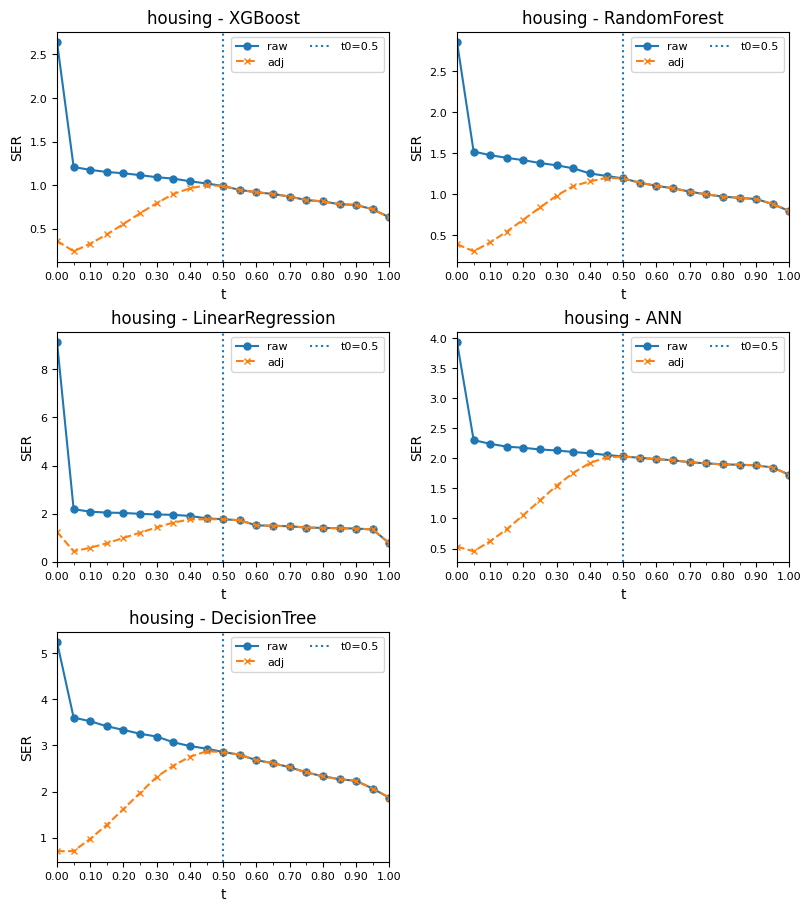

In [55]:
import glob
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

# Adjust global font sizes for clarity
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'figure.dpi': 100
})

# --- Argument parsing ---
parser = argparse.ArgumentParser(
    description="Compute and plot raw vs Gaussian-adjusted SER curves with dataset labels"
)
parser.add_argument(
    '--dir', dest='data_dir', default='predictions/',
    help='Directory with prediction CSVs'
)
parser.add_argument(
    '--pattern', dest='pattern', default='housing_preds_default_*.csv',
    help='Glob pattern for CSV files'
)
args = parser.parse_args(args=[])

# --- Load and normalize data ---
search_path = os.path.join(args.data_dir, args.pattern)
files = glob.glob(search_path)
if not files:
    raise FileNotFoundError(f"No files matching {search_path}")

df_list = []
for fn in files:
    basename = os.path.basename(fn)
    parts = basename.split('_')
    if len(parts) < 4:
        continue
    dataset = parts[0]
    phi_method = parts[2]
    model = parts[3].replace('.csv','')

    # Load predictions
    df = pd.read_csv(fn)

    # Min–Max normalize (and clip) y_true and y_pred based on y_true range
    y_min, y_max = df['y_true'].min(), df['y_true'].max()
    if y_max > y_min:
        df['y_true_norm'] = np.clip((df['y_true'] - y_min) / (y_max - y_min), 0.0, 1.0)
        df['y_pred_norm'] = np.clip((df['y_pred'] - y_min) / (y_max - y_min), 0.0, 1.0)
    else:
        # If constant target, set zeros
        df['y_true_norm'] = 0.0
        df['y_pred_norm'] = 0.0

    # Attach metadata
    df['dataset'] = dataset
    df['phi_method'] = phi_method
    df['model'] = model
    df_list.append(df)

# Combine all data into one DataFrame
all_df = pd.concat(df_list, ignore_index=True)

# --- User inputs for thresholds ---
dt = float(input("Enter Δt (0<Δt≤1, e.g. 0.05): ").strip())
if dt <= 0 or dt > 1:
    raise ValueError("Δt must be between 0 and 1.")
thresholds = np.round(np.arange(0, 1 + dt/2, dt), 3)
print("Thresholds:", thresholds)

t0 = float(input("Enter cutoff t0 (0≤t0≤1): ").strip())
t0_idx = int(np.argmin(np.abs(thresholds - t0)))
t0 = thresholds[t0_idx]
print(f"Using t0 = {t0}")

# --- Precompute Gaussian PDF centered at t0 ---
sigma = t0 / 2
weight = np.exp(-0.5 * ((thresholds - t0) / sigma) ** 2)

# --- Function for SER curve ---
def compute_ser_curve(df):
    return np.array([
        ((df['y_pred_norm'] - df['y_true_norm']) ** 2)[df['phi_val'] >= t].sum()
        for t in thresholds
    ])

# --- Collect and summarize results ---
results = []
for (dataset, phi_method, model), grp in all_df.groupby(['dataset','phi_method','model']):
    ser = compute_ser_curve(grp)
    # Gaussian-adjusted: apply weighting up to t0
    adj = np.where(thresholds <= t0, ser * weight, ser)

    # Compute areas under the curves
    raw_area = np.trapz(ser, thresholds)
    adj_area = np.trapz(adj, thresholds)

    results.append({
        'Dataset': dataset,
        'Model': model,
        'Method': phi_method,
        'Raw SERA': raw_area,
        'Adj SERA': adj_area
    })

# Build summary table
summary_df = pd.DataFrame(results).sort_values(['Dataset','Adj SERA'])
print(summary_df.to_string(index=False))

# --- Plotting with tight spacing ---
combos = summary_df[['Dataset','Model']].drop_duplicates().values.tolist()
n = len(combos)
cols = 2
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(8, 3 * rows), constrained_layout=True)
axes = axes.flatten()

for i, (dataset, model) in enumerate(combos):
    ax = axes[i]
    grp = all_df[(all_df['dataset'] == dataset) & (all_df['model'] == model)]
    ser = compute_ser_curve(grp)
    adj = np.where(thresholds <= t0, ser * weight, ser)

    ax.plot(thresholds, ser, '-', marker='o', label='raw')
    ax.plot(thresholds, adj, '--', marker='x', label='adj')
    ax.axvline(t0, linestyle=':', label=f't0={t0}')
    ax.set_title(f"{dataset} - {model}")
    ax.set_xlabel('t')
    ax.set_ylabel('SER')
    ax.set_xlim(0, 1)  # keep range [0,1]
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))   # ticks every 0.10
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))  # (optional) minor ticks
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # show 0.00, 0.10, ...
    ax.legend(loc='upper right', ncol=2)

# Remove any unused axes
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.show()

## 2️⃣ SERT Normalization – Code Walkthrough (Divide by SERT at t = 0)

**Purpose:**  
Make SERT curves unitless and comparable **without changing** the original target scale by normalizing each curve relative to its total squared error at $t=0$.

---

### **Inputs**
- **Prediction CSV files** (from Nested CV runs) with columns:
  - `y_true` — ground truth target values  
  - `y_pred` — model predictions  
  - `phi` (or `phi_val`) — relevance scores in [0, 1]
- Command-line arguments:
  - `--dir` → folder containing CSVs  
  - `--pattern` → filename pattern (e.g., `"*_preds_default_*.csv"`)

---

### **Processing Steps**
1. **Load CSVs** matching the pattern into Pandas DataFrames.
2. **Build the SERT curve** on a threshold grid $t \in [0,1]$:
   $$
   \mathrm{SERT}_t \;=\; \sum_{\phi_i \ge t} \left(y_i - \hat{y}_i\right)^2
   $$
3. **Compute the baseline** (total SSE at $t=0$):
   $$
   \mathrm{SERT}_0 \;=\; \sum_i \left(y_i - \hat{y}_i\right)^2
   $$
4. **Normalize SERT by the baseline** (relative SERT):
   $$
   \tilde{\mathrm{SERT}}_t \;=\; 
   \begin{cases}
     \dfrac{\mathrm{SERT}_t}{\mathrm{SERT}_0}, & \mathrm{SERT}_0 > 0 \\
     \mathrm{SERT}_t, & \text{otherwise (safe fallback)}
   \end{cases}
   $$
   *(In the code, a guard ensures we don’t divide by zero.)*
5. **Integrate over $t$** to get normalized SERA values:
   $$
   \mathrm{SERA}_{\text{norm}} \;=\; \int_0^1 \tilde{\mathrm{SERT}}_t\,dt
   \qquad\text{and}\qquad
   \mathrm{SERA}^{\text{adj}}_{\text{norm}} \;=\; \int_0^1 \tilde{\mathrm{SERT}}^{\text{adj}}_t\,dt
   $$
   *(Computed via numerical integration/trapezoidal rule in code.)*

---

### **Outputs**
- **Plots** labeled “SERT-normalized” with y-axis as **Relative SERT**.
- **Summary table** with “SERT Norm Raw SERA” and “SERT Norm Adj SERA”.

---

**Effect:**  
By scaling the curve to its own $\mathrm{SERT}_0$, each model/setting is compared on a **relative error profile** across relevance thresholds. This preserves the original $y$ scale for training/prediction, yet yields **unitless, cross-dataset comparable** curves and areas.


Enter Δt (0<Δt≤1, e.g. 0.05):  0.05


Thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


Enter cutoff t0 (0≤t0≤1):  0.5


Using t0 = 0.5
Dataset            Model  Method     Raw SERA     Adj SERA  SERT Norm Raw SERA  SERT Norm Adj SERA
housing LinearRegression default 3.070610e+30 8.563119e+29            0.032647            0.009104
housing          XGBoost default 5.227846e+11 3.860768e+11            0.381605            0.281815
housing     RandomForest default 6.326707e+11 4.672390e+11            0.428011            0.316094
housing              ANN default 1.079342e+12 8.296708e+11            0.528143            0.405974
housing     DecisionTree default 1.493949e+12 1.118480e+12            0.550468            0.412121


/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2544780185.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raw_area      = np.trapz(ser,       thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2544780185.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  adj_area      = np.trapz(adj,       thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2544780185.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm_raw_area = np.trapz(ser_norm,  thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2544780185.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functi

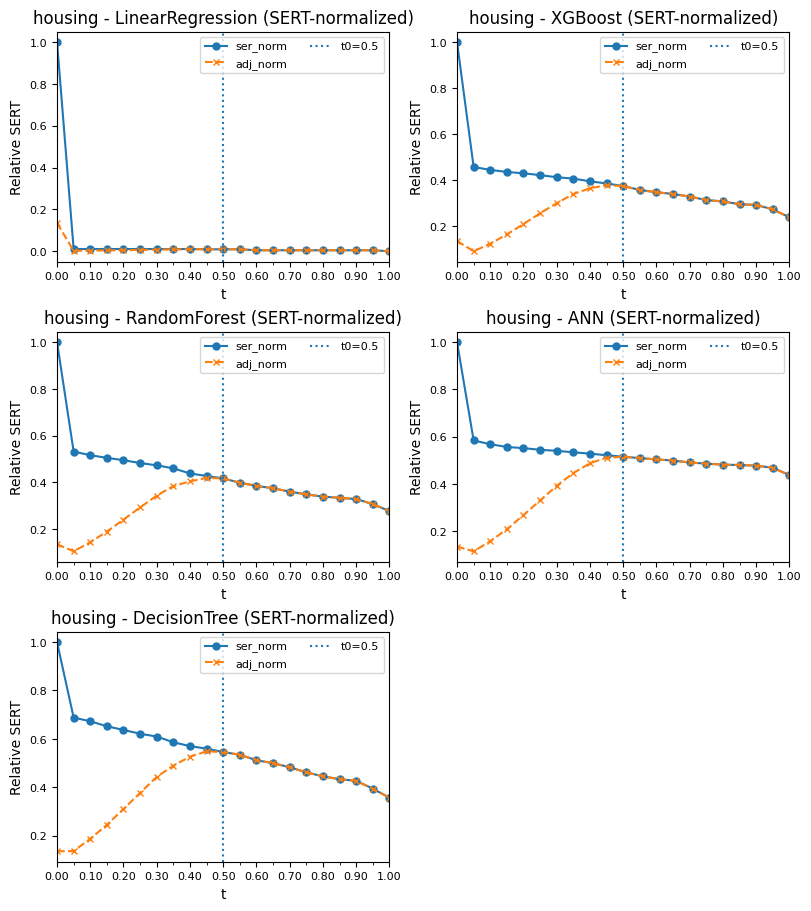

In [57]:
import glob
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Style settings
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'figure.dpi': 100
})

# --- Argument parsing ---
parser = argparse.ArgumentParser(
    description="Compute and plot raw vs adjusted vs SERT-normalized SER/SERA metrics"
)
parser.add_argument('--dir', dest='data_dir', default='predictions/', help='Directory with prediction CSVs')
parser.add_argument('--pattern', dest='pattern', default='housing_preds_default_*.csv', help='Glob pattern for CSV files')
args = parser.parse_args(args=[])

# --- Load data ---
paths = glob.glob(os.path.join(args.data_dir, args.pattern))
if not paths:
    raise FileNotFoundError(f"No files matching {args.pattern} in {args.data_dir}")

df_list = []
for path in paths:
    fname = os.path.basename(path)
    parts = fname.split('_')
    if len(parts) < 4:
        continue
    dataset, phi_method, model = parts[0], parts[2], parts[3].replace('.csv','')
    df = pd.read_csv(path)
    # keep raw y_true, y_pred unchanged
    df['dataset'], df['phi_method'], df['model'] = dataset, phi_method, model
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

# --- User inputs ---
dt = float(input("Enter Δt (0<Δt≤1, e.g. 0.05): ").strip())
if not 0 < dt <= 1:
    raise ValueError("Δt must be between 0 and 1.")
thresholds = np.round(np.arange(0, 1 + dt/2, dt), 3)
print("Thresholds:", thresholds)

t0 = float(input("Enter cutoff t0 (0≤t0≤1): ").strip())
idx0 = int(np.argmin(np.abs(thresholds - t0)))
t0 = thresholds[idx0]
print(f"Using t0 = {t0}")
# Gaussian weights for adjustment
sigma = t0/2
weight = np.exp(-0.5*((thresholds - t0)/sigma)**2)

# --- SER curve function ---
def compute_ser(df, true_col, pred_col):
    return np.array([((df[pred_col] - df[true_col])**2)[df['phi_val'] >= t].sum() for t in thresholds])

# --- Collect metrics ---
results = []
for (dataset, phi_method, model), grp in all_df.groupby(['dataset','phi_method','model']):
    # raw and adjusted SER curves on raw targets
    ser = compute_ser(grp, 'y_true', 'y_pred')
    adj = np.where(thresholds <= t0, ser*weight, ser)

    # SERT-normalized curves (divide by SERT at t=0)
    base = ser[0] if ser[0] > 0 else 1.0
    ser_norm = ser / base
    adj_norm = np.where(thresholds <= t0, ser_norm*weight, ser_norm)

    # areas (SERA)
    raw_area      = np.trapz(ser,       thresholds)
    adj_area      = np.trapz(adj,       thresholds)
    norm_raw_area = np.trapz(ser_norm,  thresholds)
    norm_adj_area = np.trapz(adj_norm,  thresholds)

    results.append({
        'Dataset':         dataset,
        'Model':           model,
        'Method':          phi_method,
        'Raw SERA':        raw_area,
        'Adj SERA':        adj_area,
        'SERT Norm Raw SERA':   norm_raw_area,
        'SERT Norm Adj SERA':   norm_adj_area
    })

summary = pd.DataFrame(results).sort_values(['Dataset','SERT Norm Adj SERA'])
print(summary.to_string(index=False))

# --- Plotting SERT-normalized curves ---
combos = summary[['Dataset','Model']].drop_duplicates().values.tolist()
n, cols = len(combos), 2
rows = int(np.ceil(n/cols))
fig, axarr = plt.subplots(rows, cols, figsize=(8,3*rows), constrained_layout=True)
axes = axarr.flatten()
for i,(dataset,model) in enumerate(combos):
    grp = all_df[(all_df['dataset']==dataset)&(all_df['model']==model)]
    ser = compute_ser(grp, 'y_true', 'y_pred')
    ser_norm = ser / (ser[0] if ser[0]>0 else 1.0)
    adj_norm = np.where(thresholds<=t0, ser_norm*weight, ser_norm)
    ax = axes[i]
    ax.plot(thresholds, ser_norm, '-', marker='o', label='ser_norm')
    ax.plot(thresholds, adj_norm, '--', marker='x', label='adj_norm')
    ax.axvline(t0, linestyle=':', label=f't0={t0}')
    ax.set_title(f"{dataset} - {model} (SERT-normalized)")
    ax.set_xlabel('t'); ax.set_ylabel('Relative SERT')
    ax.set_xlim(0, 1)  # keep range [0,1]
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))   # ticks every 0.10
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))  # (optional) minor ticks
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # show 0.00, 0.10, ...
    ax.legend(loc='upper right', ncol=2)
for j in range(n, len(axes)):
    fig.delaxes(axes[j])
plt.show()


## 3️⃣ Target + SERT Normalization — Code Walkthrough (Min–Max + Relative SERT)

**Purpose:**  
Make results unitless and comparable by (a) scaling the target/predictions to [0,1] **and** (b) re-scaling the SERT curve relative to its own baseline.

**Inputs**
- Prediction CSVs with: `y_true`, `y_pred`, `phi` (0–1), plus any labels (`model`, `φ`, `fold`, etc.).
- Args: `--dir`, `--pattern` (e.g., `housing_preds_default_*.csv`). Optional: `--xtick_step`, focus threshold `t0`.

**Processing Steps**
1. Load matching CSVs.
2. **Target normalization:** Min–Max scale `y_true` and `y_pred` to [0,1].
3. Build SERT over a threshold grid using the **normalized** values.
4. **SERT normalization:** divide the whole SERT curve by its value at `t = 0` (relative SERT).
5. (Optional) Apply emphasis around `t0` for an adjusted curve.
6. Integrate the normalized curves to produce unitless SERA summaries.
7. Plot curves and write a compact results table.

**Outputs**
- Relative SERT curves (raw + adjusted), unitless SERA scores.
- Plots for normalized versions.


Enter Δt (0<Δt≤1, e.g. 0.05):  0.05


Thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


Enter cutoff t0 (0≤t0≤1):  0.5


Using t0 = 0.5
Dataset            Model  Method  Raw SERA  Adj SERA  Norm Raw SERA  Norm Adj SERA
housing LinearRegression default  1.888628  1.321662       0.206728       0.144668
housing          XGBoost default  1.008178  0.744540       0.381605       0.281815
housing     RandomForest default  1.220091  0.901059       0.428011       0.316094
housing              ANN default  2.081213  1.599964       0.529543       0.407094
housing     DecisionTree default  2.881046  2.156963       0.550468       0.412121


/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3007427292.py:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raw_area      = np.trapz(ser,       thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3007427292.py:86: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  adj_area      = np.trapz(adj,       thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3007427292.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm_raw_area = np.trapz(ser_norm,  thresholds)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/3007427292.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functi

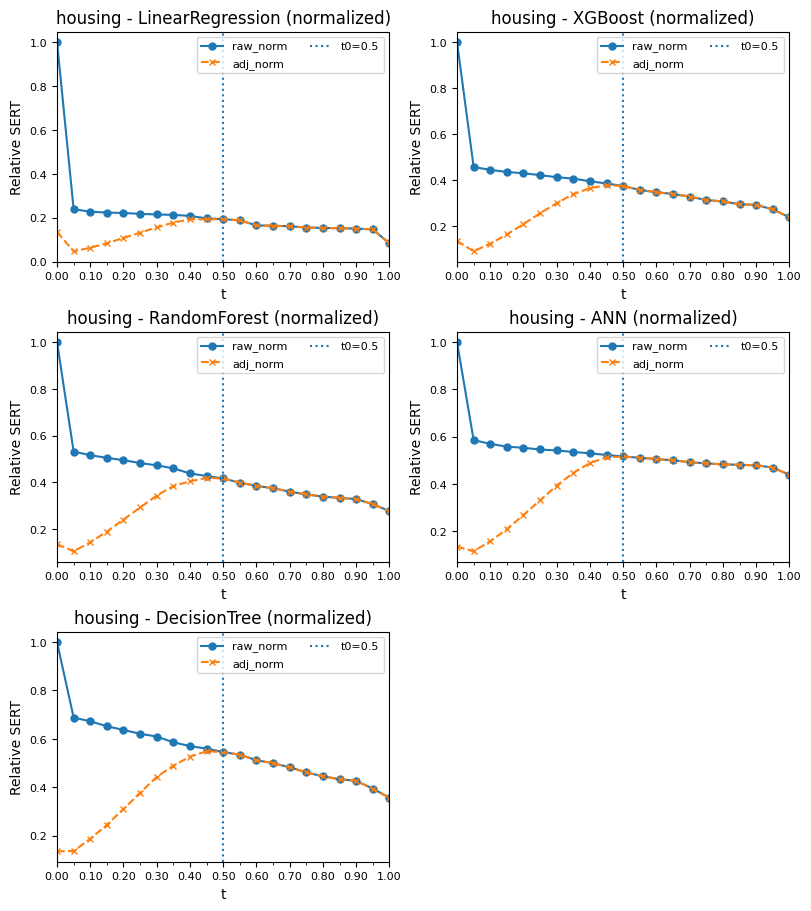

In [58]:
import glob
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Style settings
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'figure.dpi': 100
})

# --- Argument parsing ---
parser = argparse.ArgumentParser(
    description="Compute and plot raw vs adjusted vs normalized SER/SERA metrics"
)
parser.add_argument('--dir', dest='data_dir', default='predictions/', help='Directory with prediction CSVs')
parser.add_argument('--pattern', dest='pattern', default='housing_preds_default_*.csv', help='Glob pattern for CSV files')
args = parser.parse_args(args = [])

# --- Load and normalize data ---
paths = glob.glob(os.path.join(args.data_dir, args.pattern))
if not paths:
    raise FileNotFoundError(f"No files matching {args.pattern} in {args.data_dir}")

df_list = []
for path in paths:
    fname = os.path.basename(path)
    parts = fname.split('_')
    if len(parts) < 4:
        continue
    dataset, phi_method, model = parts[0], parts[2], parts[3].replace('.csv','')
    df = pd.read_csv(path)
    y_min, y_max = df['y_true'].min(), df['y_true'].max()
    if y_max > y_min:
        df['y_true_norm'] = np.clip((df['y_true'] - y_min)/(y_max - y_min), 0.0, 1.0)
        df['y_pred_norm'] = np.clip((df['y_pred'] - y_min)/(y_max - y_min), 0.0, 1.0)
    else:
        df['y_true_norm'] = 0.0
        df['y_pred_norm'] = 0.0
    df['dataset'], df['phi_method'], df['model'] = dataset, phi_method, model
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

# --- User inputs ---
dt = float(input("Enter Δt (0<Δt≤1, e.g. 0.05): ").strip())
if not 0 < dt <= 1:
    raise ValueError("Δt must be between 0 and 1.")
thresholds = np.round(np.arange(0, 1 + dt/2, dt), 3)
print("Thresholds:", thresholds)

t0 = float(input("Enter cutoff t0 (0≤t0≤1): ").strip())
idx0 = int(np.argmin(np.abs(thresholds - t0)))
t0 = thresholds[idx0]
print(f"Using t0 = {t0}")
# Gaussian weights for adjustment
sigma = t0/2
weight = np.exp(-0.5*((thresholds - t0)/sigma)**2)

# --- SER curve function ---
def compute_ser(df, true_col, pred_col):
    return np.array([((df[pred_col] - df[true_col])**2)[df['phi_val'] >= t].sum() for t in thresholds])

# --- Collect metrics ---
results = []
for (dataset, phi_method, model), grp in all_df.groupby(['dataset','phi_method','model']):
    # raw and adjusted SER curves
    ser = compute_ser(grp, 'y_true_norm', 'y_pred_norm')
    adj = np.where(thresholds <= t0, ser*weight, ser)

    # normalized by SERT at t=0
    base = ser[0] if ser[0] > 0 else 1.0
    ser_norm = ser / base
    adj_norm = np.where(thresholds <= t0, ser_norm*weight, ser_norm)

    # areas (SERA)
    raw_area      = np.trapz(ser,       thresholds)
    adj_area      = np.trapz(adj,       thresholds)
    norm_raw_area = np.trapz(ser_norm,  thresholds)
    norm_adj_area = np.trapz(adj_norm,  thresholds)

    results.append({
        'Dataset':         dataset,
        'Model':           model,
        'Method':          phi_method,
        'Raw SERA':        raw_area,
        'Adj SERA':        adj_area,
        'Norm Raw SERA':   norm_raw_area,
        'Norm Adj SERA':   norm_adj_area
    })

summary = pd.DataFrame(results).sort_values(['Dataset','Norm Adj SERA'])
print(summary.to_string(index=False))

# --- Plotting normalized curves ---
combos = summary[['Dataset','Model']].drop_duplicates().values.tolist()
n, cols = len(combos), 2
rows = int(np.ceil(n/cols))
fig, axarr = plt.subplots(rows, cols, figsize=(8,3*rows), constrained_layout=True)
axes = axarr.flatten()
for i,(dataset,model) in enumerate(combos):
    grp = all_df[(all_df['dataset']==dataset)&(all_df['model']==model)]
    ser = compute_ser(grp, 'y_true_norm', 'y_pred_norm')
    ser_norm = ser / (ser[0] if ser[0]>0 else 1.0)
    adj_norm = np.where(thresholds<=t0, ser_norm*weight, ser_norm)
    ax = axes[i]
    ax.plot(thresholds, ser_norm, '-', marker='o', label='raw_norm')
    ax.plot(thresholds, adj_norm, '--', marker='x', label='adj_norm')
    ax.axvline(t0, linestyle=':', label=f't0={t0}')
    ax.set_title(f"{dataset} - {model} (normalized)")
    ax.set_xlabel('t'); ax.set_ylabel('Relative SERT')
    ax.set_xlim(0, 1)  # keep range [0,1]
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))   # ticks every 0.10
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))  # (optional) minor ticks
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))  # show 0.00, 0.10, ...
    ax.legend(loc='upper right', ncol=2)
for j in range(n, len(axes)):
    fig.delaxes(axes[j])
plt.show()


## 4️⃣ NRMSE & NSSE Normalization — Code Walkthrough (`SERT&SERA_normalize_nrmse&nsse.py`)

**Purpose:**  
Produce **unitless, cross‑dataset comparable** SERT/SERA by normalizing cumulative squared error using a dataset scale and your choice of metric style.

---

### Inputs
- Prediction CSVs with: `y_true`, `y_pred`, `phi` (0–1), plus labels (`model`, `φ`, etc.).
- Args:
  - `--dir`, `--pattern` (e.g., `housing_preds_default_*.csv`)
  - `--norm_style {rmse,sse}` → choose normalization style:
    - `rmse` → **NRMSE** curve (default; square‑rooted)
    - `sse`  → **NSSE** curve (no square root)
  - `--scale_mode {std,iqr,max,mean}` → how to compute dataset scale `s_y` from `y_true`

---

### Processing Steps
1. Load matching CSVs and build raw SER/SERT over thresholds.
2. Compute dataset scale `s_y` using `--scale_mode` (std/iqr/max/mean).
3. Normalize cumulative error by `N·s_y²`, then:
   - if `--norm_style rmse` → output **NRMSE** curve,
   - if `--norm_style sse`  → output **NSSE** curve.
4. (Adjusted SERA) Apply emphasis/adjustment around a focus threshold `t0`.
5. Integrate the normalized curve over thresholds to get unitless SERA summaries.
6. Plot normalized curves and write a compact results table.

---

### Outputs
- **Normalized curves:** NRMSE or NSSE (per your `--norm_style`).
- **Unitless SERA:** integrated value of the chosen curve (plus adjusted variant if enabled).
- **Plots & Table:** side‑by‑side comparison across models and φ methods.

**Tuning knobs:**  
Use `--norm_style` to switch between **NRMSE** (more interpretable, same units as scaled target) and **NSSE** (proportional error).  
Use `--scale_mode` to align normalization with your data’s dispersion (e.g., `std` for Gaussian‑like, `iqr` for robust, `max/mean` for range/level).


Enter Δt (0<Δt≤1, e.g. 0.05):  0.05


Base thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


Enter cutoff t0 (0≤t0≤1):  0.5


Using t0 = 0.50
Dataset  Method            Model NormStyle ScaleMode     Raw SERA     Adj SERA    Norm SERA  Norm Adj SERA
housing default              ANN      rmse       std 1.079342e+12 8.296708e+11 3.414423e-01   2.947984e-01
housing default     DecisionTree      rmse       std 1.493949e+12 1.118480e+12 4.006283e-01   3.433431e-01
housing default LinearRegression      rmse       std 3.070610e+30 8.563119e+29 3.477528e+08   2.604932e+08
housing default     RandomForest      rmse       std 6.326707e+11 4.672390e+11 2.601257e-01   2.221826e-01
housing default          XGBoost      rmse       std 5.227846e+11 3.860768e+11 2.362427e-01   2.018403e-01


/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2185074261.py:133: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raw_sera = float(np.trapz(ser, thresholds))
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2185074261.py:134: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  adj_sera = float(np.trapz(ser_adj, thresholds))
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2185074261.py:122: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_raw = float(np.trapz(curve, thresholds))
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_62575/2185074261.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration function

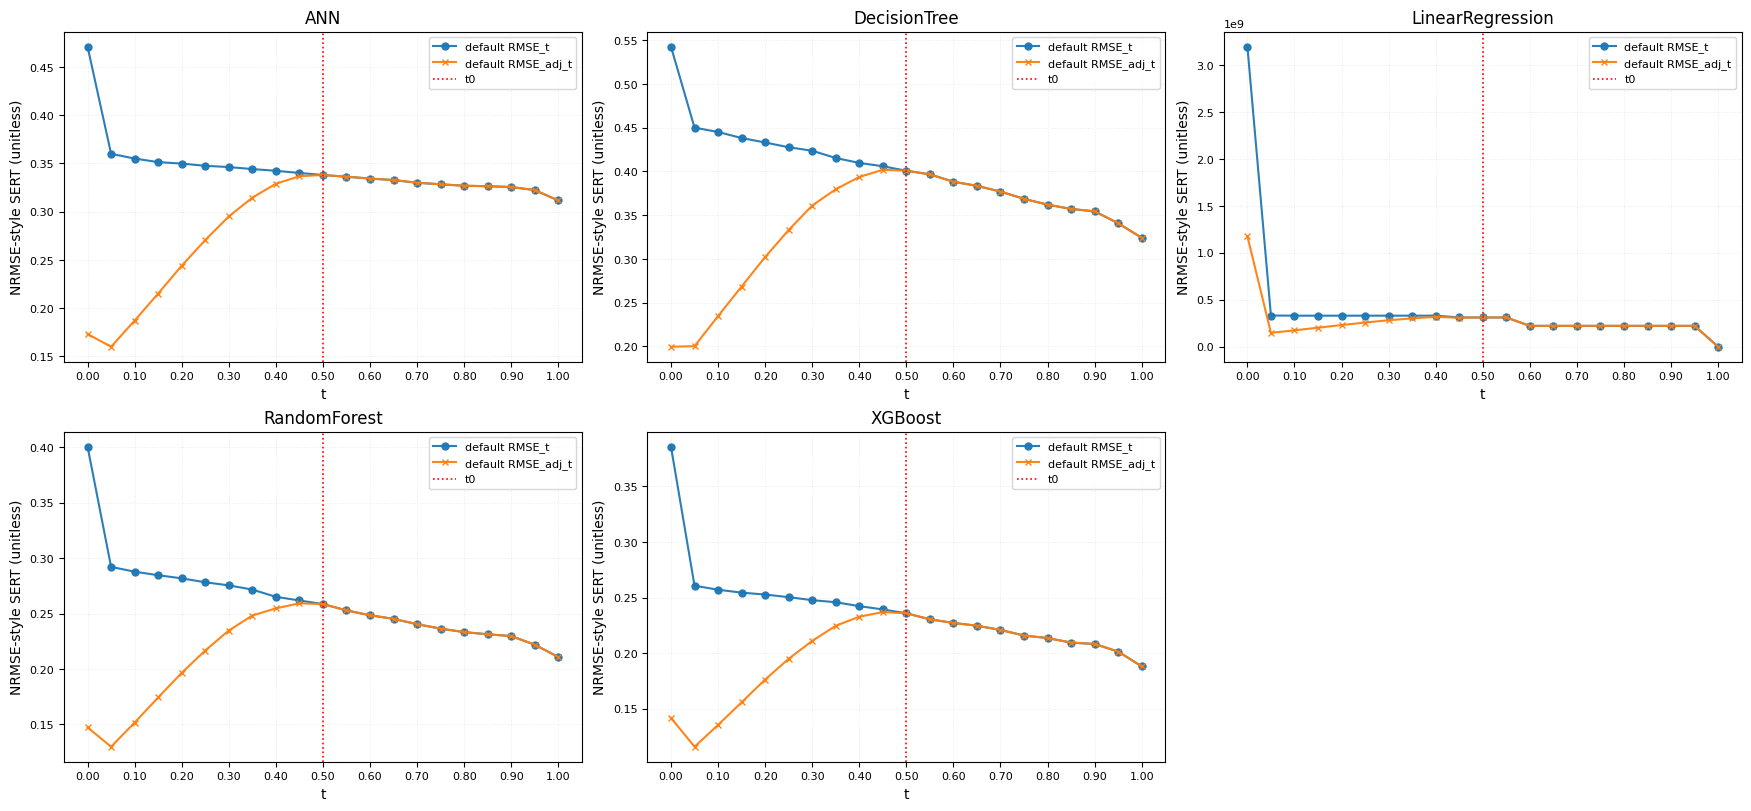

In [60]:
import glob, os, argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 10, 'axes.titlesize': 12, 'axes.labelsize': 10,
    'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
    'lines.linewidth': 1.5, 'lines.markersize': 5, 'figure.dpi': 100
})

# --------- Args ----------
parser = argparse.ArgumentParser(
    description="Compute raw/adjusted SERA and normalized SERA; plot normalized curves per model."
)
parser.add_argument('--dir', dest='data_dir', default='predictions/', help='Directory with prediction CSVs')
parser.add_argument('--pattern', dest='pattern', default='housing_preds_default_*.csv',
                    help='Glob pattern for CSV files')
parser.add_argument('--scale_mode', choices=['std','iqr','max','mean'], default='std',
                    help='Dataset scale s_y used in normalization (default: std)')
parser.add_argument('--norm_style', choices=['rmse','sse'], default='rmse',
                    help='rmse: sqrt(SER/(N*s_y^2)); sse: SER/(N*s_y^2) (no sqrt).')
parser.add_argument("--xtick_step", type=int, default=2,
                    help='Plot every k-th tick on x-axis for readability.')
args = parser.parse_args(args=[])

# --------- Load data ----------
search_path = os.path.join(args.data_dir, args.pattern)
files = glob.glob(search_path)
if not files:
    raise FileNotFoundError(f"No files matching {search_path}")

df_list = []
for fn in files:
    base = os.path.basename(fn)
    parts = base.split('_')
    if len(parts) < 4:
        continue
    # Adjust these indices to your filename pattern:
    dataset    = parts[0]
    phi_method = parts[2]
    model      = parts[3].replace('.csv', '')
    df = pd.read_csv(fn)
    # Expect columns: y_true, y_pred, phi
    if not {'y_true','y_pred','phi_val'}.issubset(df.columns):
        raise ValueError(f"Missing one of required columns (y_true,y_pred,phi) in {fn}")
    df['dataset'] = dataset
    df['phi_method'] = phi_method
    df['model'] = model
    df_list.append(df)

all_df = pd.concat(df_list, ignore_index=True)

# --------- Interactive inputs ----------
dt = float(input("Enter Δt (0<Δt≤1, e.g. 0.05): ").strip())
if dt <= 0 or dt > 1:
    raise ValueError("Δt must be between 0 and 1.")

# base grid then force-include t0 exactly
base_thresholds = np.round(np.arange(0, 1 + dt/2, dt), 6)
print("Base thresholds:", base_thresholds)

t0_user = float(input("Enter cutoff t0 (0≤t0≤1): ").strip())
t0_user = np.clip(t0_user, 0.0, 1.0)

thresholds = np.unique(np.sort(np.append(base_thresholds, t0_user)))
t0_idx = int(np.where(np.isclose(thresholds, t0_user))[0][0])
t0 = float(thresholds[t0_idx])
print(f"Using t0 = {t0:.2f}")

# --------- Gaussian weights (for raw adjusted SERA) ----------
sigma = t0 / 2 if t0 > 0 else max(dt, 1e-6)  # avoid sigma=0
weight = np.exp(-0.5 * ((thresholds - t0) / max(sigma, 1e-12))**2)

# --------- Raw SER curve (for raw/adjusted SERA) ----------
def compute_ser_curve(df, thresholds):
    se = (df['y_pred'] - df['y_true'])**2
    phi = df['phi_val']
    return np.array([se[phi >= t].sum() for t in thresholds], dtype=float)

# --------- Helpers for normalized SERT ----------
def _dataset_scale(y, mode='std'):
    y = np.asarray(y, float)
    if mode == 'std':  return max(np.std(y, ddof=1), 1e-12)
    if mode == 'iqr':
        q3, q1 = np.percentile(y, [75, 25]); return max(q3 - q1, 1e-12)
    if mode == 'max':  return max(np.max(y), 1e-12)
    if mode == 'mean': return max(np.mean(y), 1e-12)
    return 1.0

def compute_norm_sert_curve(df, thresholds, scale_mode='std', norm_style='rmse'):
    """
    Normalized cumulative SERT:
      NSSE_t = SER_t / (N * s_y^2)         # norm_style='sse'
      NRMSE_t = sqrt(NSSE_t)               # norm_style='rmse'
    Adjusted version: apply Gaussian to SER_t first, then normalize.
    """
    y   = df['y_true'].to_numpy(float)
    yp  = df['y_pred'].to_numpy(float)
    phi = df['phi_val'].to_numpy(float)
    N   = len(y)

    s_y = _dataset_scale(y, scale_mode)
    se  = (yp - y)**2

    # cumulative SSE → monotone
    ser = np.array([se[phi >= t].sum() for t in thresholds], dtype=float)
    # adjusted cumulative SSE (same logic as raw)
    adj_ser = np.where(thresholds <= t0, ser * weight, ser)

    denom = max(N * (s_y**2), 1e-12)
    nsse_curve = ser / denom
    nsse_adj   = adj_ser / denom

    if norm_style == 'rmse':
        curve = np.sqrt(nsse_curve)
        adj   = np.sqrt(nsse_adj)
    else:  # 'sse'
        curve = nsse_curve
        adj   = nsse_adj

    area_raw = float(np.trapz(curve, thresholds))
    area_adj = float(np.trapz(adj,   thresholds))
    return curve, adj, area_raw, area_adj

# --------- Compute table rows ----------
results = []
group_keys = ['dataset', 'phi_method', 'model']
for (dataset, phi_method, model), grp in all_df.groupby(group_keys):
    # Raw/Adjusted SERA (originals)
    ser = compute_ser_curve(grp, thresholds)
    ser_adj = np.where(thresholds <= t0, ser * weight, ser)
    raw_sera = float(np.trapz(ser, thresholds))
    adj_sera = float(np.trapz(ser_adj, thresholds))

    # Normalized SERA (RMSE-style or SSE-style)
    curve, adj_curve, norm_sera, norm_adj_sera = compute_norm_sert_curve(
        grp, thresholds, args.scale_mode, args.norm_style
    )

    results.append({
        'Dataset': dataset, 'Method': phi_method, 'Model': model, 
        'NormStyle': args.norm_style, 'ScaleMode': args.scale_mode, 
        'Raw SERA': raw_sera, 'Adj SERA': adj_sera,
        'Norm SERA': norm_sera, 'Norm Adj SERA': norm_adj_sera
    })

summary_df = pd.DataFrame(results).sort_values(['Dataset', 'Method', 'Model'])
print(summary_df.to_string(index=False))

# --- Plot: ONE figure, separate subplot per MODEL (normalized only) ---
models = sorted(all_df['model'].unique())
n = len(models)
cols = min(3, n)
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5.8*cols, 4.0*rows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

linestyles = ['-', '--', ':', '-.']  # one linestyle per phi_method
style_map = {}
y_label = ('NRMSE-style' if args.norm_style == 'rmse' else 'NSSE-style') + ' SERT (unitless)'

for i, model in enumerate(models):
    ax = axes[i]
    for phi_method, grp in all_df[all_df['model'] == model].groupby('phi_method'):
        curve, adj_curve, _, _ = compute_norm_sert_curve(
            grp, thresholds, args.scale_mode, args.norm_style
        )
        if phi_method not in style_map:
            style_map[phi_method] = linestyles[len(style_map) % len(linestyles)]
        ls = style_map[phi_method]
        ax.plot(thresholds, curve, linestyle=ls, marker='o', alpha=0.95,
                label=f'{phi_method} {args.norm_style.upper()}_t')
        ax.plot(thresholds, adj_curve, linestyle=ls, marker='x', alpha=0.95,
                label=f'{phi_method} {args.norm_style.upper()}_adj_t')

    ax.axvline(t0, color='red', linestyle=':', linewidth=1.2, label='t0')
    ax.set_title(model)
    ax.set_xlabel('t')
    ax.set_ylabel(y_label)

    # cleaner x ticks
    step = max(1, args.xtick_step)
    tick_pos = thresholds[::step]
    ax.set_xticks(tick_pos)
    ax.set_xticklabels([f"{x:.2f}" for x in tick_pos])
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.7)
    ax.legend(loc='upper right', fontsize=8, ncol=1)

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


## 📊 Automatic φ-Summary Table Generator

This script scans all `*_phi_default.csv` files and produces a **Table_auto_phi_summary.csv**  
summarizing **dataset characteristics** and **φ-score distributions** for the "default" φ-method.

---

### **1. Dataset Metadata Extraction**
For each CSV file:
- **dataset** → Extracted from file name (before `_phi_default.csv`)
- **n_rows** → Number of rows (instances) in the dataset
- **n_cols** → Number of columns (features + target + φ)
- **|D|** → Total number of instances (`len(df)`)

---

### **2. Nominal & Numeric Feature Counts**
- **Nom** → Number of categorical / string columns (excluding φ)
- **Num** → Number of numeric columns (excluding φ)

---

### **3. φ-Score Distribution Counts**
- **|D₁|** → Count of instances with `φ = 1.0` (max relevance)
- **|D/D₁|** → Count of instances with `φ < 1.0` (non-max relevance)
- **IR** (Imbalance Ratio) → Ratio of non-max to max relevance:
  \[
  IR = \frac{|D \setminus D₁|}{|D₁|}
  \]
  Higher IR means fewer highly relevant samples relative to others.

---

### **4. Target Outlier Type Detection**
- **Type** column indicates extreme value distribution for the target variable using **Tukey fences**:
  - `"U"` → Only upper outliers present  
  - `"L"` → Only lower outliers present  
  - `"B"` → Both upper & lower outliers present  
  - `"N"` → No outliers  
  Target is assumed to be **the column before φ** in the CSV.

---

### **5. Extra φ-Count Ranges**
These give insight into the distribution of medium-to-high relevance samples:
- **phi_0.75_0.9** → Count of instances where \( 0.75 \le \phi \le 0.90 \)  
- **phi_08_1** → Count of instances where \( 0.80 \le \phi \le 1.00 \)  
- **phi_0.9_1** → Count of instances where \( 0.90 \le \phi \le 1.00 \)  

---

### **6. Output**
- All summary rows are compiled into a **DataFrame**, sorted by dataset name, and saved as:

In [3]:
import os
import glob
import numpy as np
import pandas as pd

def detect_extreme_type(y: pd.Series):
    """Detect extreme‐value type using standard Tukey fences."""
    q1, q3 = np.percentile(y, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    has_low  = (y < lower_fence).any()
    has_high = (y > upper_fence).any()
    if has_low and has_high:
        return 'B'
    elif has_high:
        return 'U'
    elif has_low:
        return 'L'
    else:
        return 'N'  # no outliers

# directory with your default‐method phi CSVs
csv_dir = "CSV_output"
files   = glob.glob(os.path.join(csv_dir, "*_phi_default.csv"))

summary_rows = []
for path in files:
    df      = pd.read_csv(path)
    phi     = df["phi"]
    ds      = os.path.basename(path).replace("_phi_default.csv", "")

    # Table 5 columns computed on your data
    D       = len(df)                         # |D|
    Nom     = len(df.select_dtypes(include=['object','category']).columns.drop('phi', errors='ignore'))
    Num     = len(df.select_dtypes(include=[np.number]).columns.drop('phi', errors='ignore'))
    D1_bar  = int((phi < 1.0).sum())           # |D₁̸|
    D1      = int((phi == 1.0).sum())          # |D₁|
    IR      = D1_bar / D1 if D1 > 0 else np.nan
    target  = df.columns[-2]                   # assume last column before φ is the original target
    Type    = detect_extreme_type(df[target])  # U, L, B, or N

    # your extra φ‐count columns
    phi_075_09 = int(((phi >= 0.75) & (phi <= 0.90)).sum())
    phi_08_1 = int(((phi >= 0.80) & (phi <= 1.00)).sum())
    phi_09_1   = int(((phi >= 0.90) & (phi <= 1.00)).sum())

    # add n_rows and n_cols
    n_rows = df.shape[0]
    n_cols = df.shape[1]

    summary_rows.append({
        "dataset":       ds,
        "n_rows":        n_rows,
        "n_cols":        n_cols,
        "|D|":           D,
        "|D/D₁|":         D1_bar,
        "|D₁|":          D1,
        "IR":            f"{IR:.2f}",
        "Type":          Type,
        "phi_0.75_0.9":  phi_075_09,
        "phi_08_1": phi_08_1,
        "phi_0.9_1":     phi_09_1
    })

summary = pd.DataFrame(summary_rows).sort_values("dataset")
summary.to_csv("Table_auto_phi_summary.csv", index=True)
summary

dataset  n_rows  n_cols     |D|  |D/D₁|   |D₁|       IR Type  \
27               Accel    1732      16    1732    1705     27    63.15    U   
11             College     777      20     777     762     15    50.80    B   
5     Mortgage_Dataset    1049      17    1049     996     53    18.79    U   
7      Puma32h_Dataset    8192      34    8192    8067    125    64.54    B   
28         SF_Salaries  148620      10  148620  133054  15566     8.55    L   
14    Treasury_Dataset    1049      17    1049    1014     35    28.97    U   
2                   a1     198      13     198     185     13    14.23    U   
18                  a2     198      13     198     185     13    14.23    U   
26                  a3     198      13     198     175     23     7.61    U   
33                  a4     198      13     198     181     17    10.65    U   
8                   a6     198      13     198     178     20     8.90    U   
12                  a7     198      13     198     175     23     7.61    U   
19             abalone    4177      10    4177    3739    438     8.54    B   
21  airfoil_self_noise    1503       7    1503    1365    138     9.89    U   
24            availPwr    1802      17    1802    1680    122    13.77    U   
6              avocado   18249      65   18249   15951   2298     6.94    U   
16             bank8FM    4499      10    4499    4429     70    63.27    U   
17              boston     506      15     506     464     42    11.05    B   
20          california   20640      10   20640   19568   1072    18.25    U   
13               cpuSm    8192      14    8192    7735    457    16.93    L   
31                 day     731      17     731     729      2   364.50    N   
32           delta_ail    7129       7    7129    7127      2  3563.50    L   
23           delta_elv    9517       8    9517    9513      4  2378.25    U   
22       diabetic_data  101766       9  101766   98821   2945    33.56    U   
29           elevators   16599      20   16599   14837   1762     8.42    U   
3          forestfires     517      14     517     453     64     7.08    U   
9             fuelCons    1764      27    1764    1711     53    32.28    B   
30                heat    7400      13    7400    7076    324    21.84    U   
15               house   22784      18   22784   20728   2056    10.08    U   
10             housing    1460      82    1460    1337    123    10.87    U   
25           insurance    1338       8    1338    1197    141     8.49    U   
4            maxTorque    1802      21    1802    1735     67    25.90    U   
0             red_wine    1599      13    1599    1319    280     4.71    B   
1    triazine_combined    1116      14    1116    1056     60    17.60    L   

    phi_0.75_0.9  phi_08_1  phi_0.9_1  
27            41        89         61  
11            48        93         56  
5             30       106         94  
7            449       857        539  
28          3968     23977      21141  
14            65       106         66  
2              9        28         22  
18             9        22         15  
26             4        32         30  
33             7        31         27  
8              5        33         28  
12             0        27         27  
19           115       679        564  
21            89       227        138  
24            28       157        141  
6            399      2928       2668  
16           141       288        198  
17            31        91         72  
20           458      1821       1515  
13           139       713        616  
31            43        64         32  
32           118        88         30  
23           134       128         60  
22          2561      6086       4525  
29           553      2266       2025  
3              9        79         74  
9             95       164        105  
30           204       664        525  
15           490      2874       2563  
10            96       251        191  
25       

## 📄 KL / Fréchet Comparison Summary – Column Guide

This script scans `CSV_output/*_phi_*.csv` files and compares **φ (relevance) distributions** produced by different methods against the **default** method for each dataset.

### Inputs
- Folder: `CSV_output/` with one file per dataset × φ‑method (e.g., `housing_phi_default.csv`, `housing_phi_gmm.csv`).
- Known target column names are mapped in `known_targets`; if a dataset isn’t listed, the script falls back to “the first non‑φ column”.

### What it does (quick)
1. Group files per dataset; keep only datasets that have a `*_phi_default.csv`.
2. For every non‑default method present (from `["gmm","kde","hist","spectral"]`), load φ values and:
   - Compute **KL divergence** vs. default (how different the distributions are).
   - Compute **1‑Wasserstein (Fréchet) distance** vs. default (how far the mass must move).
3. (Helper `get_blocks` finds target intervals for specific φ levels, but its outputs are currently not included—kept for future use.)
4. Write a per‑dataset summary CSV.

### Output file
- **Filename:** `KL_FRICHET_comparison_summary.csv`  
  *(Note: the `print` line says `comparison_summary.csv`; the actual saved name is the one above.)*

### Columns (what each means)
- **Dataset** – Dataset key inferred from the filename prefix (e.g., `housing`, `College`).
- **Rows** – Number of rows in the **default** file for that dataset.
- **Cols** – Number of columns in the **default** file (includes features/target/φ).

For each **non‑default** φ method that exists for the dataset (e.g., `gmm`, `kde`, `hist`, `spectral`), two columns are added:

- **`{method}_KL`** – Kullback–Leibler divergence between the method’s φ distribution and the default φ distribution (lower → more similar to default).
- **`{method}_Fréchet`** – 1‑Wasserstein distance between the method’s φ values and the default φ values (lower → closer to default).

> Example: For `gmm`, you’ll see `gmm_KL` and `gmm_Fréchet`.

### Notes & tips
- If you want to add interval listings for where φ is minimal/maximal (by target ranges), uncomment the two lines that populate:
  - `f"{m}_Rel=0"` → intervals where φ is at/near its **minimum**,
  - `f"{m}_Rel=1"` → intervals where φ is at/near its **maximum**.
- Ensure each dataset has a `*_phi_default.csv`; otherwise it’s skipped.
- If a dataset’s target column name isn’t in `known_targets`, the script uses the **first non‑φ column** it finds.


In [7]:
import os
import pandas as pd
import numpy as np
from scipy.stats import entropy, wasserstein_distance

# --- Settings --- #
methods = ["default", "gmm", "kde", "hist", "spectral"]
csv_dir  = "CSV_output"

# --- Dataset → target mapping --- #
known_targets = {'abalone': 'Sex', 
                'housing': 'SalePrice', 
                'Accel': 'acceleration', 
                'airfoil_self_noise': 'Frequency_Hz', 
                'forestfires': 'area', 
                'fuelCons': 'fuel.consumption.country',
                'College': 'Grad.Rate',
                'heat': 'heat', 
                'availPwr': 'available.power', 
                'boston': 'HousValue', 
                'Mortgage_Dataset': '30Y-CMortgageRate', 
                'insurance': 'charges', 
                'avocado': 'Total Volume', 
                'bank8FM': 'rej', 
                'elevators': 'Goal', 
                'diabetic_data': 'num_medications', 
                'delta_ail': 'RollRate',
                'delta_elv': 'climbRate', 
                'maxTorque': 'maximal.torque', 
                'house': 'Price', 
                'triazine_combined': 'activity', 
                'red_wine': 'quality',
                'Puma32h_Dataset': 'thetadd6', 
                'a1': 'a1',  'a2': 'a2', 'a3': 'a3', 'a4': 'a4', 'a6': 'a6', 'a7': 'a7', 
                'california': 'MedianHouseValue',
                'cpuSm': 'usr',
                'Treasury_Dataset': '1MonthCDRate', 
                'SF_Salaries': 'TotalPayBenefits'}

def compute_kl(p, q):
    p = np.array(p) + 1e-8
    q = np.array(q) + 1e-8
    p /= p.sum()
    q /= q.sum()
    return entropy(p, q)

def get_blocks(phi_vals, target_vals, rel):
    """
    rel==0 → central (min-φ) cluster
    rel==1 → both tails (max-φ and its near-duplicates)
    else   → exact φ-match

    Returns a list of (min, max) for each contiguous block in target-sorted order.
    """
    phi  = np.array(phi_vals, dtype=float)
    targ = np.array(target_vals, dtype=float)

    # sort by the target so blocks correspond to true x-intervals
    order = np.argsort(targ)
    phi   = phi[order]
    targ  = targ[order]

    # find unique φ-values to set a dynamic tolerance
    uniq = np.unique(phi)
    tiny = 1e-8

    if rel == 0:
        level = uniq[0]
        # tol = gap to the next φ
        tol   = (uniq[1] - level) + tiny if uniq.size > 1 else tiny
        mask  = phi <= level + tol

    elif rel == 1:
        level = uniq[-1]
        # tol = gap down to the second-highest φ
        tol   = (level - uniq[-2]) + tiny if uniq.size > 1 else tiny
        mask  = phi >= level - tol

    else:
        level = rel
        tol   = tiny
        mask  = np.isclose(phi, level, atol=tol)

    # if nothing matches, return empty list
    if not mask.any():
        return []

    # scan for contiguous True runs
    blocks = []
    in_run = False
    for i, m in enumerate(mask):
        if m and not in_run:
            in_run   = True
            start_ix = i
        elif not m and in_run:
            seg = targ[start_ix:i]
            blocks.append((seg.min(), seg.max()))
            in_run = False
    if in_run:
        seg = targ[start_ix:]
        blocks.append((seg.min(), seg.max()))

    return blocks

# --- Load and group your files --- #
datasets = {}
for fn in os.listdir(csv_dir):
    if not fn.endswith(".csv"): continue
    base, method = fn[:-4].split("_phi_")
    if method == "manual": continue
    datasets.setdefault(base, {})[method] = os.path.join(csv_dir, fn)

# --- Build the comparison table --- #
rows = []
for ds, files in datasets.items():
    if "default" not in files: continue

    df0 = pd.read_csv(files["default"])
    if "phi" not in df0: continue

    target_col = known_targets.get(
        ds,
        next((c for c in df0.columns if c != "phi"), None)
    )
    if not target_col: continue

    row = {
        "Dataset": ds,
        "Rows":    len(df0),
        "Cols":    len(df0.columns)
    }

    for m in methods:
        if m == "default" or m not in files: continue

        dfm = pd.read_csv(files[m])
        kl  = compute_kl(df0["phi"], dfm["phi"])
        fr  = wasserstein_distance(df0["phi"], dfm["phi"])

        b0 = get_blocks(dfm["phi"], dfm[target_col], 0)
        b1 = get_blocks(dfm["phi"], dfm[target_col], 1)

        fmt = lambda bl: (
            "[" +
            ", ".join(f"[{lo:.2f}, {hi:.2f}]" for lo, hi in bl) +
            "]"
        ) if bl else "-"

        row.update({
            f"{m}_KL":       round(float(kl), 4),
            f"{m}_Fréchet":  round(float(fr), 4),
            # f"{m}_Rel=0":    fmt(b0),
            # f"{m}_Rel=1":    fmt(b1),
        })

    rows.append(row)

results = pd.DataFrame(rows)
results.to_csv("KL_FRICHET_comparison_summary.csv", index=False)
print("Comparison summary saved to: comparison_summary.csv")
results

Comparison summary saved to: comparison_summary.csv


Dataset    Rows  Cols  gmm_KL  gmm_Fréchet  kde_KL  \
0      Puma32h_Dataset    8192    34  0.0807       0.1349  0.0531   
1            delta_elv    9517     8  0.6209       0.1707  0.6658   
2             red_wine    1599    13  0.0567       0.2117  8.9750   
3                   a6     198    13  0.3459       0.2276  0.0951   
4    triazine_combined    1116    14  0.4878       0.2037  0.3649   
5                 heat    7400    13  0.6063       0.2725  0.3802   
6                   a2     198    13  0.7785       0.4505  0.3838   
7   airfoil_self_noise    1503     7  0.6473       0.3487  0.3742   
8                   a1     198    13  0.7525       0.4305  0.3879   
9               boston     506    15  0.0493       0.0936  0.0516   
10         forestfires     517    14  0.5238       0.2974  0.3489   
11            fuelCons    1764    27  0.0414       0.0267  0.0936   
12                  a7     198    13  0.5632       0.3051  0.1526   
13               house   22784    18  0.6021       0.2895  0.3315   
14           maxTorque    1802    21  0.5539       0.2393  0.4811   
15    Mortgage_Dataset    1049    17  0.5637       0.2524  0.5709   
16           elevators   16599    20  0.4951       0.2002  0.4431   
17                 day     731    17  0.8212       0.2554  0.7483   
18             avocado   18249    65  0.4627       0.2407  0.2351   
19             College     777    20  0.0630       0.0576  0.0420   
20       diabetic_data  101766     9  0.4407       0.1520  0.4745   
21               Accel    1732    16  0.6165       0.1816  0.6133   
22                  a3     198    13  0.5948       0.2861  0.2680   
23          california   20640    10  0.5918       0.2646  0.4145   
24               cpuSm    8192    14  4.4671       0.3472  0.3508   
25           delta_ail    7129     7  0.7045       0.1679  0.7541   
26                  a4     198    13  0.2135       0.1996  0.0661   
27             housing    1460    82  0.2765       0.0556  0.2762   
28             abalone    4177    10  6.3404       0.2618  6.3404   
29           insurance    1338     8  0.6348       0.2865  0.3707   
30             bank8FM    4499    10  0.8341       0.4676  0.5239   
31         SF_Salaries  148620    10  0.5455       0.2421  0.4452   
32            availPwr    1802    17  0.5293       0.2228  0.4497   
33    Treasury_Dataset    1049    17  0.5945       0.2523  0.4511   

    kde_Fréchet  hist_KL  hist_Fréchet  spectral_KL  spectral_Fréchet  
0        0.1041   0.6065        0.1485       0.1491            0.2189  
1        0.1996   0.5607        0.2431       0.7504            0.3720  
2        0.2247   8.9668        0.2271       0.1960            0.1527  
3        0.0897   0.3007        0.1923       1.2858            0.2818  
4        0.1429   0.7211        0.2265       0.8725            0.3176  
5        0.1638   0.5235        0.2538       0.8864            0.3313  
6        0.1997   0.6754        0.3615       0.9919            0.3192  
7        0.1935   0.7864        0.4561       0.9566            0.2970  
8        0.2106   0.8941        0.5253       0.9177            0.2936  
9        0.0914   0.8474        0.1687       0.1713            0.1696  
10       0.1013   0.5212        0.2896       2.1047            0.2946  
11       0.0516   1.6629        0.0730       0.1304            0.2154  
12       0.0895   0.4760        0.2482       1.3297            0.3173  
13       0.1539   0.6459        0.3165       1.0967            0.3151  
14       0.1979   0.6048        0.3037       0.8858            0.3430  
15       0.2609   0.8939        0.5011       0.8630            0.3219  
16       0.1764   0.6739        0.2919       1.0488            0.3183  
17       0.2198   1.2210        0.2554       0.7723            0.3111  
18       0.0857   1.2019        0.7442       2.1307            0.3004  
19       0.0430   0.2698        0.1252       0.1130            0.1910  
20       0.1632   0.4078        0.1896       0.8989            0.3537  
21       0.1923

---

## 📌 Conclusion

This tutorial provided a **complete walkthrough** of the SMOGN Regression Evaluation Toolkit — from understanding **imbalanced regression challenges** to implementing **relevance-weighted error metrics** (SERA & SERT), applying **SMOGN oversampling**, and performing **robust model benchmarking** using Nested Cross-Validation.

We explored:
- **Custom metrics** for fair, cross-dataset model evaluation.
- **Multiple φ-estimation methods** (control points, density estimation, histograms, spectral methods).
- **Automation** of workflows for training, evaluation, and result summarization.
- **Analysis tools** to compare models across diverse datasets.

This framework is designed for **research reproducibility** and **extensibility**, enabling experimentation with new models, relevance functions, and normalization strategies.

**🔗 Full Project Repository:**  
All source code, datasets, and scripts for this tutorial are available on GitHub:  
[https://github.com/Bhavneet345/COOP2025_IMBALANCE_REGRESSION](https://github.com/Bhavneet345/COOP2025_IMBALANCE_REGRESSION)

---
